In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow_datasets as tfds
from keras import Model, layers
from tensorflow.keras import initializers

import imageio as iio
import pickle
import random
import os
import re
from tqdm import tqdm
from PIL import Image
from matplotlib import cm
from matplotlib import pyplot as plt
from mini_lucid_tf2 import objectives, transformations, render


# Select whether Angle or Power shall be loaded
angle = False
closed = True
domain = "_A_" if angle else "_P_" 
print_domain = "Phase" if angle else "Power" 
condition = "_closed" if closed else "_open" 

os.chdir('/home/bpn/Documents/Max/P8_final')

# Load and transform data
The data, already split by test and train IDs, is read from files, and the P8 slices are transformed to RBG images

In [2]:

# Load P8 Data
p8_train = np.load("Data/p8_train%s%s.npy"%(domain, condition))
p8_test = np.load("Data/p8_test%s%s.npy"%(domain, condition))

p8_train_pics = []
p8_test_pics = []

# With this function, the P8 slices are transformed to RGB images. 
# Angle matrices are min-max scaled (min value = 0 and max value = 1), as required to convert it to RGB. 
# Both Angle and Phase matrices are then multiplied by 255 to fit the scale of RGB images
def tensor_to_pic(tensor_list, angle, empty_list):
    for matrix in tqdm(tensor_list):
        if angle:
            transmat = (matrix - matrix.min()) / (matrix.max() - matrix.min())
            im = Image.fromarray(np.uint8(np.round(cm.twilight(transmat)*255))).rotate(180)
        else:
            im = Image.fromarray(np.uint8(cm.magma(matrix)*255)).rotate(180)
        pic = np.array(im)[:,:,:3] # Select RGB channels
        empty_list.append(pic/255)
    
    return empty_list

# Applying the function
p8_train_pics = tensor_to_pic(p8_train, angle, p8_train_pics)
p8_test_pics = tensor_to_pic(p8_test, angle, p8_test_pics)


train_targets = np.load("Data/target_train%s%s.npy"%(domain, condition))
test_targets = np.load("Data/target_test%s%s.npy"%(domain, condition))


100%|██████████████████████████████████████| 1898/1898 [00:03<00:00, 529.88it/s]


# Transform data to tf.Dataset

The numpy arrays of training and testing volumes are transformed to tensorflow Datasets and batched. To free memory, the numpy arrays used to build the tensorflow datasets are deleted to free memory. 

In [3]:
## Pics to TensorFlow Datasets

def pics_to_datasets(picture_list, target_list, batch_size, batch_to_load = 10):   
    
    dataset = tf.data.Dataset.from_tensor_slices((picture_list[0:2], target_list[0:2]))
    for i in tqdm(range(2,len(picture_list), batch_to_load)):
        temp_dataset = tf.data.Dataset.from_tensor_slices((picture_list[i:(i+batch_to_load)], target_list[i:(i+batch_to_load)]))
        dataset = dataset.concatenate(temp_dataset) 
    
    # Batch subset
    dataset = dataset.batch(batch_size)
    
    return dataset

batch_size = 32
trainset = pics_to_datasets(p8_train_pics, train_targets, batch_size, 25)
testset = pics_to_datasets(p8_test_pics, test_targets, batch_size, 25)


2022-03-27 09:40:35.645852: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-27 09:40:36.387572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22220 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
100%|███████████████████████████████████████████| 76/76 [00:41<00:00,  1.83it/s]


## Check Data Leakage
Check if split by participant worked, or if any chunk is duplicated between test and train set


In [5]:
# Iterating over all train images and within this loop over all test images. 
# If the first dimension fits, the whole volumes are compared
for pic in tqdm(p8_train_pics):
    for pic_2 in p8_test_pics:
        if np.all(pic[1,:,:] == pic_2[1,:,:]):
            if np.all(pic == pic_2):
                print("watch out")
                

100%|██████████████████████████████████████| 2774/2774 [00:21<00:00, 130.96it/s]


## Display sample picture

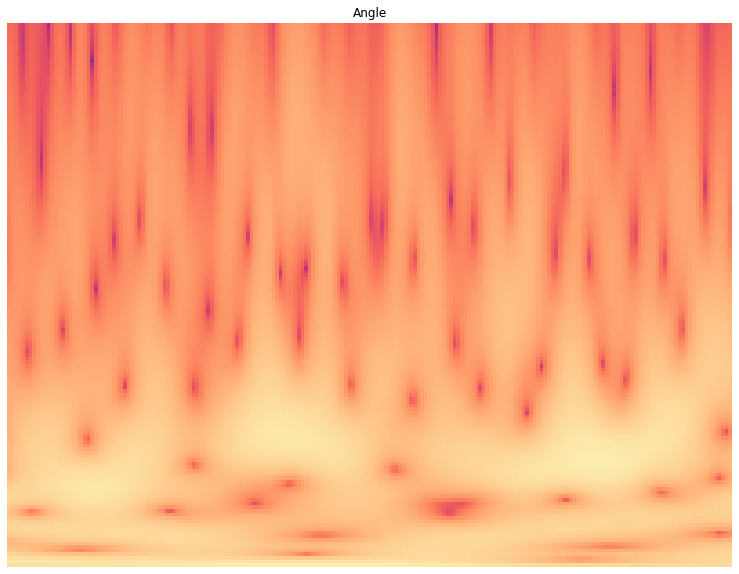

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (20,10))
ax.set_title("Angle")
ax.axis('off')
ax.imshow(p8_train_pics[0])
plt.show()

# Modeling

In this step, the model architecture is built and the model's paramters are specified (Learning Rate, Dropout, Optimizer, Regularization, Weight initialization). Then, the model is trained with the AUC and the accuracy as metrics to monitor during training. A best model is saved each time a new highest validtion AUC is achieved during training (with the ModelCheckpoints callback). Additionally, training can be stopped when an training AUC of 1 is reached, as this indicates overfitting (--> overfit_callback; not applied for the analysis reported in the thesis).

In [22]:

viz_model = tf.keras.models.Sequential()
viz_model.add(layers.BatchNormalization())
viz_model.add(layers.Conv2D(32, (5, 5), activation='relu'))
viz_model.add(layers.MaxPooling2D((2, 2)))
viz_model.add(layers.BatchNormalization())
viz_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
viz_model.add(layers.MaxPooling2D((2, 2)))
viz_model.add(layers.BatchNormalization())
viz_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
viz_model.add(layers.MaxPooling2D((2, 2)))
viz_model.add(layers.BatchNormalization())
viz_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
viz_model.add(layers.MaxPooling2D((2, 2)))
viz_model.add(layers.BatchNormalization())
viz_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
viz_model.add(layers.GlobalAveragePooling2D())
viz_model.add(layers.Dropout(0.5))
viz_model.add(layers.Dense(256, activation='relu')) 
viz_model.add(layers.Dense(1, activation='sigmoid'))

#Function to add regularization and to initialize weights in all layer that allow this.
# (Function adapted from GitHub: https://sthalles.github.io/keras-regularizer/).
def add_regularization(model, regularizer, initializer):

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
                setattr(layer, attr, regularizer)
                
        for attr in ['kernel_initializer']:
            if hasattr(layer, attr):
                setattr(layer, attr, initializer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()
    model = tf.keras.models.model_from_json(model_json)
    
    return model

# Apply previously defined function to add regularization and weight inititalization
viz_model = add_regularization(viz_model, 
                               initializer = keras.initializers.RandomNormal(stddev = 1.0, seed = 270597), 
                               regularizer = tf.keras.regularizers.l2(1e-01))

# Define Optimizer with Learning Rate
adam = keras.optimizers.Adam(learning_rate=1e-05)

# Compile the Model with AUC and Accuracy as metrics
viz_model.compile(optimizer=adam, 
                  loss='binary_crossentropy', 
                  metrics=[tf.keras.metrics.AUC(from_logits=True, name = 'AUC'), 'accuracy'])


Epoch 1/5000
87/87 [==============================] - 5s 41ms/step - loss: 18315.4141 - AUC: 0.5039 - accuracy: 0.4398 - val_loss: 19141.2207 - val_AUC: 0.5000 - val_accuracy: 0.3846
Epoch 2/5000
87/87 [==============================] - 3s 37ms/step - loss: 18257.6250 - AUC: 0.4942 - accuracy: 0.4337 - val_loss: 18183.5137 - val_AUC: 0.5000 - val_accuracy: 0.3846
Epoch 3/5000
87/87 [==============================] - 3s 37ms/step - loss: 18148.7285 - AUC: 0.5102 - accuracy: 0.4528 - val_loss: 18018.6914 - val_AUC: 0.5000 - val_accuracy: 0.3846
Epoch 4/5000
87/87 [==============================] - 3s 38ms/step - loss: 18088.1797 - AUC: 0.5091 - accuracy: 0.4567 - val_loss: 17852.4902 - val_AUC: 0.5000 - val_accuracy: 0.3846
Epoch 5/5000
87/87 [==============================] - 3s 39ms/step - loss: 18023.6914 - AUC: 0.5020 - accuracy: 0.4546 - val_loss: 17690.8379 - val_AUC: 0.5004 - val_accuracy: 0.3851
Epoch 6/5000
87/87 [==============================] - 3s 39ms/step - loss: 17922.5898

87/87 [==============================] - 3s 36ms/step - loss: 16666.6309 - AUC: 0.5947 - accuracy: 0.6049 - val_loss: 16685.7891 - val_AUC: 0.4724 - val_accuracy: 0.5685
Epoch 90/5000
87/87 [==============================] - 3s 36ms/step - loss: 16654.2637 - AUC: 0.5941 - accuracy: 0.6009 - val_loss: 16674.7031 - val_AUC: 0.4736 - val_accuracy: 0.5701
Epoch 91/5000
87/87 [==============================] - 3s 37ms/step - loss: 16635.4668 - AUC: 0.5975 - accuracy: 0.6049 - val_loss: 16662.6250 - val_AUC: 0.4748 - val_accuracy: 0.5717
Epoch 92/5000
87/87 [==============================] - 3s 37ms/step - loss: 16629.9043 - AUC: 0.5952 - accuracy: 0.6045 - val_loss: 16650.2539 - val_AUC: 0.4748 - val_accuracy: 0.5722
Epoch 93/5000
87/87 [==============================] - 3s 37ms/step - loss: 16635.6289 - AUC: 0.5818 - accuracy: 0.5919 - val_loss: 16637.7344 - val_AUC: 0.4744 - val_accuracy: 0.5722
Epoch 94/5000
87/87 [==============================] - 3s 37ms/step - loss: 16622.6309 - AUC: 

87/87 [==============================] - 3s 36ms/step - loss: 15571.0195 - AUC: 0.5995 - accuracy: 0.6053 - val_loss: 15589.7676 - val_AUC: 0.4813 - val_accuracy: 0.5722
Epoch 178/5000
87/87 [==============================] - 3s 36ms/step - loss: 15548.5361 - AUC: 0.6231 - accuracy: 0.6345 - val_loss: 15575.8057 - val_AUC: 0.4843 - val_accuracy: 0.5738
Epoch 179/5000
87/87 [==============================] - 3s 36ms/step - loss: 15550.3574 - AUC: 0.6044 - accuracy: 0.6139 - val_loss: 15563.6455 - val_AUC: 0.4843 - val_accuracy: 0.5748
Epoch 180/5000
87/87 [==============================] - 3s 37ms/step - loss: 15540.5596 - AUC: 0.6030 - accuracy: 0.6121 - val_loss: 15548.6670 - val_AUC: 0.4848 - val_accuracy: 0.5764
Epoch 181/5000
87/87 [==============================] - 3s 37ms/step - loss: 15509.7705 - AUC: 0.6207 - accuracy: 0.6291 - val_loss: 15534.2803 - val_AUC: 0.4854 - val_accuracy: 0.5764
Epoch 182/5000
87/87 [==============================] - 3s 36ms/step - loss: 15506.2158 - 

87/87 [==============================] - 3s 36ms/step - loss: 14467.7119 - AUC: 0.6038 - accuracy: 0.6103 - val_loss: 14475.7754 - val_AUC: 0.4889 - val_accuracy: 0.5780
Epoch 266/5000
87/87 [==============================] - 3s 37ms/step - loss: 14459.9902 - AUC: 0.6105 - accuracy: 0.6193 - val_loss: 14463.0107 - val_AUC: 0.4900 - val_accuracy: 0.5790
Epoch 267/5000
87/87 [==============================] - 3s 36ms/step - loss: 14440.2051 - AUC: 0.6269 - accuracy: 0.6352 - val_loss: 14450.0439 - val_AUC: 0.4906 - val_accuracy: 0.5780
Epoch 268/5000
87/87 [==============================] - 3s 37ms/step - loss: 14433.3467 - AUC: 0.6168 - accuracy: 0.6247 - val_loss: 14437.1914 - val_AUC: 0.4904 - val_accuracy: 0.5790
Epoch 269/5000
87/87 [==============================] - 3s 37ms/step - loss: 14412.0938 - AUC: 0.6276 - accuracy: 0.6370 - val_loss: 14423.8076 - val_AUC: 0.4895 - val_accuracy: 0.5769
Epoch 270/5000
87/87 [==============================] - 3s 37ms/step - loss: 14397.8281 - 

87/87 [==============================] - 3s 36ms/step - loss: 13372.6680 - AUC: 0.6216 - accuracy: 0.6301 - val_loss: 13375.0547 - val_AUC: 0.4943 - val_accuracy: 0.5774
Epoch 354/5000
87/87 [==============================] - 3s 36ms/step - loss: 13360.4170 - AUC: 0.6131 - accuracy: 0.6186 - val_loss: 13362.9521 - val_AUC: 0.4943 - val_accuracy: 0.5774
Epoch 355/5000
87/87 [==============================] - 3s 37ms/step - loss: 13347.9795 - AUC: 0.6199 - accuracy: 0.6255 - val_loss: 13351.9092 - val_AUC: 0.4941 - val_accuracy: 0.5790
Epoch 356/5000
87/87 [==============================] - 3s 36ms/step - loss: 13332.3301 - AUC: 0.6365 - accuracy: 0.6467 - val_loss: 13339.0762 - val_AUC: 0.4948 - val_accuracy: 0.5759
Epoch 357/5000
87/87 [==============================] - 3s 36ms/step - loss: 13327.5820 - AUC: 0.6202 - accuracy: 0.6258 - val_loss: 13326.0117 - val_AUC: 0.4943 - val_accuracy: 0.5764
Epoch 358/5000
87/87 [==============================] - 3s 36ms/step - loss: 13312.1357 - 

87/87 [==============================] - 3s 36ms/step - loss: 12292.8047 - AUC: 0.6241 - accuracy: 0.6334 - val_loss: 12294.5762 - val_AUC: 0.4954 - val_accuracy: 0.5785
Epoch 442/5000
87/87 [==============================] - 3s 37ms/step - loss: 12278.6289 - AUC: 0.6361 - accuracy: 0.6431 - val_loss: 12282.6855 - val_AUC: 0.4933 - val_accuracy: 0.5764
Epoch 443/5000
87/87 [==============================] - 3s 37ms/step - loss: 12270.0459 - AUC: 0.6204 - accuracy: 0.6233 - val_loss: 12271.7588 - val_AUC: 0.4923 - val_accuracy: 0.5759
Epoch 444/5000
87/87 [==============================] - 3s 37ms/step - loss: 12257.6455 - AUC: 0.6266 - accuracy: 0.6352 - val_loss: 12257.8486 - val_AUC: 0.4901 - val_accuracy: 0.5748
Epoch 445/5000
87/87 [==============================] - 3s 38ms/step - loss: 12245.0010 - AUC: 0.6255 - accuracy: 0.6334 - val_loss: 12245.0479 - val_AUC: 0.4926 - val_accuracy: 0.5774
Epoch 446/5000
87/87 [==============================] - 3s 37ms/step - loss: 12230.2139 - 

87/87 [==============================] - 3s 36ms/step - loss: 11237.8027 - AUC: 0.6240 - accuracy: 0.6276 - val_loss: 11235.5078 - val_AUC: 0.4993 - val_accuracy: 0.5722
Epoch 530/5000
87/87 [==============================] - 3s 37ms/step - loss: 11231.4775 - AUC: 0.6153 - accuracy: 0.6229 - val_loss: 11223.4082 - val_AUC: 0.5028 - val_accuracy: 0.5743
Epoch 531/5000
87/87 [==============================] - 3s 37ms/step - loss: 11215.8877 - AUC: 0.6277 - accuracy: 0.6341 - val_loss: 11211.1768 - val_AUC: 0.5005 - val_accuracy: 0.5738
Epoch 532/5000
87/87 [==============================] - 3s 37ms/step - loss: 11204.0078 - AUC: 0.6304 - accuracy: 0.6391 - val_loss: 11199.5068 - val_AUC: 0.5015 - val_accuracy: 0.5738
Epoch 533/5000
87/87 [==============================] - 3s 36ms/step - loss: 11193.3633 - AUC: 0.6195 - accuracy: 0.6233 - val_loss: 11189.3574 - val_AUC: 0.4977 - val_accuracy: 0.5727
Epoch 534/5000
87/87 [==============================] - 3s 36ms/step - loss: 11182.2793 - 

87/87 [==============================] - 3s 37ms/step - loss: 10213.1631 - AUC: 0.6297 - accuracy: 0.6381 - val_loss: 10209.5967 - val_AUC: 0.4973 - val_accuracy: 0.5638
Epoch 618/5000
87/87 [==============================] - 3s 37ms/step - loss: 10204.6582 - AUC: 0.6223 - accuracy: 0.6273 - val_loss: 10198.4150 - val_AUC: 0.4963 - val_accuracy: 0.5648
Epoch 619/5000
87/87 [==============================] - 3s 37ms/step - loss: 10193.0820 - AUC: 0.6185 - accuracy: 0.6247 - val_loss: 10187.3193 - val_AUC: 0.4951 - val_accuracy: 0.5653
Epoch 620/5000
87/87 [==============================] - 3s 36ms/step - loss: 10177.4727 - AUC: 0.6408 - accuracy: 0.6485 - val_loss: 10176.1426 - val_AUC: 0.4952 - val_accuracy: 0.5627
Epoch 621/5000
87/87 [==============================] - 3s 37ms/step - loss: 10166.6758 - AUC: 0.6282 - accuracy: 0.6334 - val_loss: 10164.1650 - val_AUC: 0.4956 - val_accuracy: 0.5643
Epoch 622/5000
87/87 [==============================] - 3s 37ms/step - loss: 10158.1504 - 

Epoch 662/5000
87/87 [==============================] - 3s 37ms/step - loss: 9704.8799 - AUC: 0.6159 - accuracy: 0.6211 - val_loss: 9698.6387 - val_AUC: 0.5017 - val_accuracy: 0.5622
Epoch 663/5000
87/87 [==============================] - 3s 36ms/step - loss: 9692.7031 - AUC: 0.6272 - accuracy: 0.6352 - val_loss: 9686.9473 - val_AUC: 0.4983 - val_accuracy: 0.5653
Epoch 664/5000
87/87 [==============================] - 3s 37ms/step - loss: 9681.4727 - AUC: 0.6297 - accuracy: 0.6352 - val_loss: 9675.5225 - val_AUC: 0.4998 - val_accuracy: 0.5659
Epoch 665/5000
87/87 [==============================] - 3s 36ms/step - loss: 9671.2031 - AUC: 0.6257 - accuracy: 0.6287 - val_loss: 9664.6777 - val_AUC: 0.5006 - val_accuracy: 0.5638
Epoch 666/5000
87/87 [==============================] - 3s 36ms/step - loss: 9659.2002 - AUC: 0.6364 - accuracy: 0.6406 - val_loss: 9653.6592 - val_AUC: 0.5000 - val_accuracy: 0.5643
Epoch 667/5000
87/87 [==============================] - 3s 37ms/step - loss: 9648.085

Epoch 707/5000
87/87 [==============================] - 3s 36ms/step - loss: 9204.0518 - AUC: 0.6195 - accuracy: 0.6208 - val_loss: 9197.9209 - val_AUC: 0.4981 - val_accuracy: 0.5648
Epoch 708/5000
87/87 [==============================] - 3s 36ms/step - loss: 9190.2305 - AUC: 0.6439 - accuracy: 0.6528 - val_loss: 9186.1973 - val_AUC: 0.4996 - val_accuracy: 0.5643
Epoch 709/5000
87/87 [==============================] - 3s 37ms/step - loss: 9178.5029 - AUC: 0.6365 - accuracy: 0.6442 - val_loss: 9174.9072 - val_AUC: 0.4980 - val_accuracy: 0.5659
Epoch 710/5000
87/87 [==============================] - 3s 36ms/step - loss: 9171.4619 - AUC: 0.6293 - accuracy: 0.6366 - val_loss: 9163.7656 - val_AUC: 0.4970 - val_accuracy: 0.5616
Epoch 711/5000
87/87 [==============================] - 3s 36ms/step - loss: 9160.5342 - AUC: 0.6238 - accuracy: 0.6280 - val_loss: 9152.5488 - val_AUC: 0.4973 - val_accuracy: 0.5606
Epoch 712/5000
87/87 [==============================] - 3s 37ms/step - loss: 9146.113

Epoch 752/5000
87/87 [==============================] - 3s 37ms/step - loss: 8711.5381 - AUC: 0.6306 - accuracy: 0.6309 - val_loss: 8705.7861 - val_AUC: 0.4962 - val_accuracy: 0.5601
Epoch 753/5000
87/87 [==============================] - 3s 36ms/step - loss: 8700.7500 - AUC: 0.6232 - accuracy: 0.6294 - val_loss: 8694.8887 - val_AUC: 0.4961 - val_accuracy: 0.5611
Epoch 754/5000
87/87 [==============================] - 3s 37ms/step - loss: 8688.3887 - AUC: 0.6348 - accuracy: 0.6435 - val_loss: 8683.9082 - val_AUC: 0.4970 - val_accuracy: 0.5574
Epoch 755/5000
87/87 [==============================] - 3s 37ms/step - loss: 8678.2148 - AUC: 0.6233 - accuracy: 0.6262 - val_loss: 8673.0459 - val_AUC: 0.4972 - val_accuracy: 0.5580
Epoch 756/5000
87/87 [==============================] - 3s 36ms/step - loss: 8668.3828 - AUC: 0.6283 - accuracy: 0.6334 - val_loss: 8662.6738 - val_AUC: 0.4943 - val_accuracy: 0.5569
Epoch 757/5000
87/87 [==============================] - 3s 37ms/step - loss: 8659.076

Epoch 797/5000
87/87 [==============================] - 3s 37ms/step - loss: 8229.3906 - AUC: 0.6405 - accuracy: 0.6442 - val_loss: 8225.0576 - val_AUC: 0.4951 - val_accuracy: 0.5548
Epoch 798/5000
87/87 [==============================] - 3s 37ms/step - loss: 8222.1904 - AUC: 0.6196 - accuracy: 0.6276 - val_loss: 8214.4893 - val_AUC: 0.4958 - val_accuracy: 0.5548
Epoch 799/5000
87/87 [==============================] - 3s 37ms/step - loss: 8211.1807 - AUC: 0.6457 - accuracy: 0.6518 - val_loss: 8203.7900 - val_AUC: 0.4936 - val_accuracy: 0.5553
Epoch 800/5000
87/87 [==============================] - 3s 36ms/step - loss: 8198.5811 - AUC: 0.6401 - accuracy: 0.6453 - val_loss: 8193.4512 - val_AUC: 0.4953 - val_accuracy: 0.5548
Epoch 801/5000
87/87 [==============================] - 3s 36ms/step - loss: 8191.1440 - AUC: 0.6163 - accuracy: 0.6215 - val_loss: 8183.3354 - val_AUC: 0.4941 - val_accuracy: 0.5537
Epoch 802/5000
87/87 [==============================] - 3s 37ms/step - loss: 8178.180

Epoch 842/5000
87/87 [==============================] - 3s 36ms/step - loss: 7764.3555 - AUC: 0.6290 - accuracy: 0.6341 - val_loss: 7757.9731 - val_AUC: 0.4892 - val_accuracy: 0.5501
Epoch 843/5000
87/87 [==============================] - 3s 37ms/step - loss: 7754.1782 - AUC: 0.6426 - accuracy: 0.6420 - val_loss: 7748.0493 - val_AUC: 0.4884 - val_accuracy: 0.5485
Epoch 844/5000
87/87 [==============================] - 3s 37ms/step - loss: 7742.3750 - AUC: 0.6397 - accuracy: 0.6431 - val_loss: 7737.7197 - val_AUC: 0.4890 - val_accuracy: 0.5479
Epoch 845/5000
87/87 [==============================] - 3s 37ms/step - loss: 7732.9365 - AUC: 0.6304 - accuracy: 0.6330 - val_loss: 7727.3896 - val_AUC: 0.4906 - val_accuracy: 0.5485
Epoch 846/5000
87/87 [==============================] - 3s 36ms/step - loss: 7722.3794 - AUC: 0.6279 - accuracy: 0.6352 - val_loss: 7716.8970 - val_AUC: 0.4894 - val_accuracy: 0.5495
Epoch 847/5000
87/87 [==============================] - 3s 36ms/step - loss: 7710.626

Epoch 887/5000
87/87 [==============================] - 3s 37ms/step - loss: 7306.5254 - AUC: 0.6408 - accuracy: 0.6435 - val_loss: 7301.5356 - val_AUC: 0.4838 - val_accuracy: 0.5479
Epoch 888/5000
87/87 [==============================] - 3s 37ms/step - loss: 7298.1558 - AUC: 0.6229 - accuracy: 0.6240 - val_loss: 7291.3745 - val_AUC: 0.4841 - val_accuracy: 0.5469
Epoch 889/5000
87/87 [==============================] - 3s 37ms/step - loss: 7286.9761 - AUC: 0.6275 - accuracy: 0.6330 - val_loss: 7281.3125 - val_AUC: 0.4844 - val_accuracy: 0.5506
Epoch 890/5000
87/87 [==============================] - 3s 37ms/step - loss: 7275.9302 - AUC: 0.6357 - accuracy: 0.6410 - val_loss: 7270.8145 - val_AUC: 0.4876 - val_accuracy: 0.5511
Epoch 891/5000
87/87 [==============================] - 3s 37ms/step - loss: 7267.5532 - AUC: 0.6295 - accuracy: 0.6337 - val_loss: 7261.3018 - val_AUC: 0.4843 - val_accuracy: 0.5495
Epoch 892/5000
87/87 [==============================] - 3s 36ms/step - loss: 7256.865

Epoch 932/5000
87/87 [==============================] - 3s 38ms/step - loss: 6862.8438 - AUC: 0.6386 - accuracy: 0.6449 - val_loss: 6857.6182 - val_AUC: 0.4795 - val_accuracy: 0.5374
Epoch 933/5000
87/87 [==============================] - 3s 37ms/step - loss: 6853.2168 - AUC: 0.6397 - accuracy: 0.6438 - val_loss: 6847.8062 - val_AUC: 0.4781 - val_accuracy: 0.5379
Epoch 934/5000
87/87 [==============================] - 3s 37ms/step - loss: 6843.4058 - AUC: 0.6355 - accuracy: 0.6413 - val_loss: 6838.0474 - val_AUC: 0.4801 - val_accuracy: 0.5379
Epoch 935/5000
87/87 [==============================] - 3s 38ms/step - loss: 6834.3823 - AUC: 0.6375 - accuracy: 0.6373 - val_loss: 6828.3198 - val_AUC: 0.4796 - val_accuracy: 0.5379
Epoch 936/5000
87/87 [==============================] - 3s 37ms/step - loss: 6823.1245 - AUC: 0.6504 - accuracy: 0.6547 - val_loss: 6818.5020 - val_AUC: 0.4805 - val_accuracy: 0.5358
Epoch 937/5000
87/87 [==============================] - 3s 38ms/step - loss: 6814.137

Epoch 977/5000
87/87 [==============================] - 3s 37ms/step - loss: 6431.4468 - AUC: 0.6329 - accuracy: 0.6363 - val_loss: 6426.2939 - val_AUC: 0.4799 - val_accuracy: 0.5353
Epoch 978/5000
87/87 [==============================] - 3s 37ms/step - loss: 6421.5835 - AUC: 0.6392 - accuracy: 0.6388 - val_loss: 6416.8481 - val_AUC: 0.4815 - val_accuracy: 0.5369
Epoch 979/5000
87/87 [==============================] - 3s 37ms/step - loss: 6412.3647 - AUC: 0.6417 - accuracy: 0.6438 - val_loss: 6407.3892 - val_AUC: 0.4821 - val_accuracy: 0.5364
Epoch 980/5000
87/87 [==============================] - 3s 38ms/step - loss: 6403.2817 - AUC: 0.6422 - accuracy: 0.6474 - val_loss: 6397.7656 - val_AUC: 0.4829 - val_accuracy: 0.5374
Epoch 981/5000
87/87 [==============================] - 3s 37ms/step - loss: 6393.5615 - AUC: 0.6392 - accuracy: 0.6399 - val_loss: 6388.1763 - val_AUC: 0.4832 - val_accuracy: 0.5369
Epoch 982/5000
87/87 [==============================] - 3s 37ms/step - loss: 6384.499

Epoch 1022/5000
87/87 [==============================] - 3s 38ms/step - loss: 6012.0078 - AUC: 0.6558 - accuracy: 0.6565 - val_loss: 6008.4482 - val_AUC: 0.4778 - val_accuracy: 0.5258
Epoch 1023/5000
87/87 [==============================] - 3s 37ms/step - loss: 6003.1270 - AUC: 0.6484 - accuracy: 0.6482 - val_loss: 5999.3237 - val_AUC: 0.4804 - val_accuracy: 0.5316
Epoch 1024/5000
87/87 [==============================] - 3s 38ms/step - loss: 5994.9912 - AUC: 0.6406 - accuracy: 0.6413 - val_loss: 5990.0645 - val_AUC: 0.4807 - val_accuracy: 0.5274
Epoch 1025/5000
87/87 [==============================] - 3s 37ms/step - loss: 5986.5269 - AUC: 0.6430 - accuracy: 0.6446 - val_loss: 5981.0010 - val_AUC: 0.4822 - val_accuracy: 0.5311
Epoch 1026/5000
87/87 [==============================] - 3s 38ms/step - loss: 5976.8921 - AUC: 0.6305 - accuracy: 0.6373 - val_loss: 5971.7573 - val_AUC: 0.4833 - val_accuracy: 0.5311
Epoch 1027/5000
87/87 [==============================] - 3s 37ms/step - loss: 59

87/87 [==============================] - 3s 37ms/step - loss: 5235.8711 - AUC: 0.6615 - accuracy: 0.6601 - val_loss: 5231.9980 - val_AUC: 0.4708 - val_accuracy: 0.5311
Epoch 1111/5000
87/87 [==============================] - 3s 38ms/step - loss: 5227.6343 - AUC: 0.6451 - accuracy: 0.6424 - val_loss: 5223.3711 - val_AUC: 0.4716 - val_accuracy: 0.5290
Epoch 1112/5000
87/87 [==============================] - 3s 37ms/step - loss: 5219.3311 - AUC: 0.6436 - accuracy: 0.6424 - val_loss: 5214.8711 - val_AUC: 0.4688 - val_accuracy: 0.5279
Epoch 1113/5000
87/87 [==============================] - 3s 38ms/step - loss: 5211.5708 - AUC: 0.6373 - accuracy: 0.6384 - val_loss: 5206.3438 - val_AUC: 0.4648 - val_accuracy: 0.5216
Epoch 1114/5000
87/87 [==============================] - 3s 38ms/step - loss: 5202.6382 - AUC: 0.6434 - accuracy: 0.6395 - val_loss: 5197.9014 - val_AUC: 0.4647 - val_accuracy: 0.5205
Epoch 1115/5000
87/87 [==============================] - 3s 38ms/step - loss: 5193.9834 - AUC: 0

87/87 [==============================] - 3s 37ms/step - loss: 4515.6787 - AUC: 0.6640 - accuracy: 0.6590 - val_loss: 4511.9199 - val_AUC: 0.4588 - val_accuracy: 0.5285
Epoch 1199/5000
87/87 [==============================] - 3s 37ms/step - loss: 4508.4902 - AUC: 0.6417 - accuracy: 0.6428 - val_loss: 4503.9741 - val_AUC: 0.4587 - val_accuracy: 0.5269
Epoch 1200/5000
87/87 [==============================] - 3s 37ms/step - loss: 4500.7969 - AUC: 0.6448 - accuracy: 0.6424 - val_loss: 4496.3223 - val_AUC: 0.4561 - val_accuracy: 0.5269
Epoch 1201/5000
87/87 [==============================] - 3s 38ms/step - loss: 4492.5918 - AUC: 0.6532 - accuracy: 0.6474 - val_loss: 4488.5654 - val_AUC: 0.4563 - val_accuracy: 0.5253
Epoch 1202/5000
87/87 [==============================] - 3s 39ms/step - loss: 4484.8530 - AUC: 0.6483 - accuracy: 0.6435 - val_loss: 4480.7461 - val_AUC: 0.4569 - val_accuracy: 0.5269
Epoch 1203/5000
87/87 [==============================] - 3s 37ms/step - loss: 4477.7925 - AUC: 0

87/87 [==============================] - 3s 37ms/step - loss: 3856.8171 - AUC: 0.6422 - accuracy: 0.6366 - val_loss: 3852.4077 - val_AUC: 0.4651 - val_accuracy: 0.5327
Epoch 1287/5000
87/87 [==============================] - 3s 37ms/step - loss: 3849.1968 - AUC: 0.6648 - accuracy: 0.6521 - val_loss: 3845.2537 - val_AUC: 0.4654 - val_accuracy: 0.5316
Epoch 1288/5000
87/87 [==============================] - 3s 37ms/step - loss: 3842.1135 - AUC: 0.6578 - accuracy: 0.6500 - val_loss: 3838.1111 - val_AUC: 0.4635 - val_accuracy: 0.5300
Epoch 1289/5000
87/87 [==============================] - 3s 38ms/step - loss: 3834.8081 - AUC: 0.6551 - accuracy: 0.6485 - val_loss: 3831.0156 - val_AUC: 0.4645 - val_accuracy: 0.5342
Epoch 1290/5000
87/87 [==============================] - 3s 37ms/step - loss: 3827.5750 - AUC: 0.6684 - accuracy: 0.6640 - val_loss: 3823.8828 - val_AUC: 0.4649 - val_accuracy: 0.5306
Epoch 1291/5000
87/87 [==============================] - 3s 37ms/step - loss: 3820.8564 - AUC: 0

87/87 [==============================] - 3s 37ms/step - loss: 3259.0588 - AUC: 0.6516 - accuracy: 0.6373 - val_loss: 3255.1833 - val_AUC: 0.4790 - val_accuracy: 0.5458
Epoch 1375/5000
87/87 [==============================] - 3s 37ms/step - loss: 3252.4839 - AUC: 0.6574 - accuracy: 0.6399 - val_loss: 3248.8428 - val_AUC: 0.4795 - val_accuracy: 0.5453
Epoch 1376/5000
87/87 [==============================] - 3s 37ms/step - loss: 3246.2263 - AUC: 0.6507 - accuracy: 0.6438 - val_loss: 3242.5576 - val_AUC: 0.4752 - val_accuracy: 0.5479
Epoch 1377/5000
87/87 [==============================] - 3s 38ms/step - loss: 3239.9470 - AUC: 0.6437 - accuracy: 0.6309 - val_loss: 3236.1519 - val_AUC: 0.4763 - val_accuracy: 0.5485
Epoch 1378/5000
87/87 [==============================] - 3s 37ms/step - loss: 3233.1519 - AUC: 0.6707 - accuracy: 0.6518 - val_loss: 3229.8325 - val_AUC: 0.4756 - val_accuracy: 0.5469
Epoch 1379/5000
87/87 [==============================] - 3s 37ms/step - loss: 3227.0173 - AUC: 0

87/87 [==============================] - 3s 36ms/step - loss: 2725.6912 - AUC: 0.6756 - accuracy: 0.6456 - val_loss: 2722.6768 - val_AUC: 0.4778 - val_accuracy: 0.5595
Epoch 1463/5000
87/87 [==============================] - 3s 37ms/step - loss: 2720.1023 - AUC: 0.6636 - accuracy: 0.6442 - val_loss: 2716.9641 - val_AUC: 0.4798 - val_accuracy: 0.5648
Epoch 1464/5000
87/87 [==============================] - 3s 37ms/step - loss: 2714.4907 - AUC: 0.6644 - accuracy: 0.6388 - val_loss: 2711.3701 - val_AUC: 0.4807 - val_accuracy: 0.5643
Epoch 1465/5000
87/87 [==============================] - 3s 36ms/step - loss: 2708.6753 - AUC: 0.6656 - accuracy: 0.6482 - val_loss: 2705.7056 - val_AUC: 0.4818 - val_accuracy: 0.5643
Epoch 1466/5000
87/87 [==============================] - 3s 36ms/step - loss: 2703.1772 - AUC: 0.6502 - accuracy: 0.6352 - val_loss: 2700.0078 - val_AUC: 0.4763 - val_accuracy: 0.5638
Epoch 1467/5000
87/87 [==============================] - 3s 36ms/step - loss: 2697.4241 - AUC: 0

87/87 [==============================] - 3s 38ms/step - loss: 2257.3015 - AUC: 0.6919 - accuracy: 0.6637 - val_loss: 2254.6719 - val_AUC: 0.5050 - val_accuracy: 0.5780
Epoch 1551/5000
87/87 [==============================] - 3s 37ms/step - loss: 2252.3455 - AUC: 0.6788 - accuracy: 0.6496 - val_loss: 2249.7297 - val_AUC: 0.5020 - val_accuracy: 0.5764
Epoch 1552/5000
87/87 [==============================] - 3s 38ms/step - loss: 2247.4233 - AUC: 0.6778 - accuracy: 0.6464 - val_loss: 2244.7856 - val_AUC: 0.5053 - val_accuracy: 0.5780
Epoch 1553/5000
87/87 [==============================] - 3s 37ms/step - loss: 2242.6318 - AUC: 0.6775 - accuracy: 0.6525 - val_loss: 2239.8596 - val_AUC: 0.5059 - val_accuracy: 0.5785
Epoch 1554/5000
87/87 [==============================] - 3s 37ms/step - loss: 2237.6111 - AUC: 0.6662 - accuracy: 0.6467 - val_loss: 2234.9365 - val_AUC: 0.5031 - val_accuracy: 0.5764
Epoch 1555/5000
87/87 [==============================] - 3s 36ms/step - loss: 2232.7676 - AUC: 0

87/87 [==============================] - 3s 37ms/step - loss: 1852.8032 - AUC: 0.6931 - accuracy: 0.6586 - val_loss: 1850.6965 - val_AUC: 0.5070 - val_accuracy: 0.5827
Epoch 1639/5000
87/87 [==============================] - 3s 37ms/step - loss: 1848.6105 - AUC: 0.6828 - accuracy: 0.6518 - val_loss: 1846.4630 - val_AUC: 0.5081 - val_accuracy: 0.5817
Epoch 1640/5000
87/87 [==============================] - 3s 37ms/step - loss: 1844.3767 - AUC: 0.6830 - accuracy: 0.6428 - val_loss: 1842.2147 - val_AUC: 0.5112 - val_accuracy: 0.5827
Epoch 1641/5000
87/87 [==============================] - 3s 37ms/step - loss: 1840.1348 - AUC: 0.6888 - accuracy: 0.6539 - val_loss: 1838.0039 - val_AUC: 0.5091 - val_accuracy: 0.5832
Epoch 1642/5000
87/87 [==============================] - 3s 37ms/step - loss: 1835.9653 - AUC: 0.6782 - accuracy: 0.6464 - val_loss: 1833.8030 - val_AUC: 0.5083 - val_accuracy: 0.5848
Epoch 1643/5000
87/87 [==============================] - 3s 37ms/step - loss: 1831.7523 - AUC: 0

87/87 [==============================] - 3s 37ms/step - loss: 1508.9178 - AUC: 0.6986 - accuracy: 0.6561 - val_loss: 1507.2083 - val_AUC: 0.5221 - val_accuracy: 0.5859
Epoch 1727/5000
87/87 [==============================] - 3s 37ms/step - loss: 1505.3549 - AUC: 0.6887 - accuracy: 0.6453 - val_loss: 1503.6709 - val_AUC: 0.5253 - val_accuracy: 0.5896
Epoch 1728/5000
87/87 [==============================] - 3s 36ms/step - loss: 1501.7429 - AUC: 0.7054 - accuracy: 0.6637 - val_loss: 1500.0802 - val_AUC: 0.5301 - val_accuracy: 0.5885
Epoch 1729/5000
87/87 [==============================] - 3s 38ms/step - loss: 1498.2656 - AUC: 0.6892 - accuracy: 0.6521 - val_loss: 1496.5140 - val_AUC: 0.5288 - val_accuracy: 0.5880
Epoch 1730/5000
87/87 [==============================] - 3s 37ms/step - loss: 1494.7622 - AUC: 0.6822 - accuracy: 0.6366 - val_loss: 1492.9806 - val_AUC: 0.5316 - val_accuracy: 0.5906
Epoch 1731/5000
87/87 [==============================] - 3s 37ms/step - loss: 1491.1764 - AUC: 0

87/87 [==============================] - 3s 37ms/step - loss: 1221.1151 - AUC: 0.7149 - accuracy: 0.6676 - val_loss: 1219.7628 - val_AUC: 0.5454 - val_accuracy: 0.5991
Epoch 1815/5000
87/87 [==============================] - 3s 37ms/step - loss: 1218.1755 - AUC: 0.7055 - accuracy: 0.6640 - val_loss: 1216.7654 - val_AUC: 0.5518 - val_accuracy: 0.5996
Epoch 1816/5000
87/87 [==============================] - 3s 37ms/step - loss: 1215.1859 - AUC: 0.7063 - accuracy: 0.6665 - val_loss: 1213.7996 - val_AUC: 0.5479 - val_accuracy: 0.5954
Epoch 1817/5000
87/87 [==============================] - 3s 37ms/step - loss: 1212.2560 - AUC: 0.7074 - accuracy: 0.6622 - val_loss: 1210.8721 - val_AUC: 0.5423 - val_accuracy: 0.5938
Epoch 1818/5000
87/87 [==============================] - 3s 37ms/step - loss: 1209.3301 - AUC: 0.7037 - accuracy: 0.6651 - val_loss: 1207.9431 - val_AUC: 0.5378 - val_accuracy: 0.5927
Epoch 1819/5000
87/87 [==============================] - 3s 36ms/step - loss: 1206.4314 - AUC: 0

Epoch 1903/5000
87/87 [==============================] - 3s 40ms/step - loss: 981.1066 - AUC: 0.7119 - accuracy: 0.6662 - val_loss: 979.9655 - val_AUC: 0.5548 - val_accuracy: 0.6159
Epoch 1904/5000
87/87 [==============================] - 3s 37ms/step - loss: 978.6726 - AUC: 0.7055 - accuracy: 0.6575 - val_loss: 977.5415 - val_AUC: 0.5534 - val_accuracy: 0.6128
Epoch 1905/5000
87/87 [==============================] - 3s 36ms/step - loss: 976.2324 - AUC: 0.7132 - accuracy: 0.6658 - val_loss: 975.1165 - val_AUC: 0.5524 - val_accuracy: 0.6096
Epoch 1906/5000
87/87 [==============================] - 3s 36ms/step - loss: 973.8215 - AUC: 0.7061 - accuracy: 0.6640 - val_loss: 972.6772 - val_AUC: 0.5542 - val_accuracy: 0.6101
Epoch 1907/5000
87/87 [==============================] - 3s 36ms/step - loss: 971.3677 - AUC: 0.7136 - accuracy: 0.6611 - val_loss: 970.2764 - val_AUC: 0.5520 - val_accuracy: 0.6075
Epoch 1908/5000
87/87 [==============================] - 3s 37ms/step - loss: 968.9562 - A

87/87 [==============================] - 3s 37ms/step - loss: 876.8727 - AUC: 0.6994 - accuracy: 0.6532 - val_loss: 875.8297 - val_AUC: 0.5523 - val_accuracy: 0.6154
Epoch 1949/5000
87/87 [==============================] - 3s 37ms/step - loss: 874.6137 - AUC: 0.7168 - accuracy: 0.6683 - val_loss: 873.6608 - val_AUC: 0.5432 - val_accuracy: 0.6122
Epoch 1950/5000
87/87 [==============================] - 3s 37ms/step - loss: 872.4014 - AUC: 0.7277 - accuracy: 0.6817 - val_loss: 871.4528 - val_AUC: 0.5489 - val_accuracy: 0.6070
Epoch 1951/5000
87/87 [==============================] - 3s 37ms/step - loss: 870.2208 - AUC: 0.7278 - accuracy: 0.6734 - val_loss: 869.2825 - val_AUC: 0.5470 - val_accuracy: 0.6080
Epoch 1952/5000
87/87 [==============================] - 3s 37ms/step - loss: 868.0972 - AUC: 0.7085 - accuracy: 0.6615 - val_loss: 867.1164 - val_AUC: 0.5444 - val_accuracy: 0.6059
Epoch 1953/5000
87/87 [==============================] - 3s 36ms/step - loss: 865.8593 - AUC: 0.7214 - acc

87/87 [==============================] - 3s 38ms/step - loss: 698.3073 - AUC: 0.7241 - accuracy: 0.6712 - val_loss: 697.5814 - val_AUC: 0.5342 - val_accuracy: 0.5969
Epoch 2039/5000
87/87 [==============================] - 3s 36ms/step - loss: 696.5094 - AUC: 0.7291 - accuracy: 0.6745 - val_loss: 695.8131 - val_AUC: 0.5337 - val_accuracy: 0.5975
Epoch 2040/5000
87/87 [==============================] - 3s 38ms/step - loss: 694.7347 - AUC: 0.7374 - accuracy: 0.6954 - val_loss: 694.0314 - val_AUC: 0.5319 - val_accuracy: 0.5975
Epoch 2041/5000
87/87 [==============================] - 3s 37ms/step - loss: 692.9741 - AUC: 0.7358 - accuracy: 0.6900 - val_loss: 692.2540 - val_AUC: 0.5431 - val_accuracy: 0.6012
Epoch 2042/5000
87/87 [==============================] - 3s 37ms/step - loss: 691.2369 - AUC: 0.7251 - accuracy: 0.6727 - val_loss: 690.4990 - val_AUC: 0.5381 - val_accuracy: 0.5996
Epoch 2043/5000
87/87 [==============================] - 3s 37ms/step - loss: 689.4573 - AUC: 0.7265 - acc

87/87 [==============================] - 3s 37ms/step - loss: 554.1638 - AUC: 0.7392 - accuracy: 0.6860 - val_loss: 553.6232 - val_AUC: 0.5285 - val_accuracy: 0.6027
Epoch 2129/5000
87/87 [==============================] - 3s 37ms/step - loss: 552.7050 - AUC: 0.7516 - accuracy: 0.6957 - val_loss: 552.1904 - val_AUC: 0.5320 - val_accuracy: 0.6033
Epoch 2130/5000
87/87 [==============================] - 3s 37ms/step - loss: 551.2942 - AUC: 0.7409 - accuracy: 0.6882 - val_loss: 550.7569 - val_AUC: 0.5354 - val_accuracy: 0.6038
Epoch 2131/5000
87/87 [==============================] - 3s 37ms/step - loss: 549.8788 - AUC: 0.7359 - accuracy: 0.6857 - val_loss: 549.3193 - val_AUC: 0.5364 - val_accuracy: 0.6022
Epoch 2132/5000
87/87 [==============================] - 3s 37ms/step - loss: 548.4126 - AUC: 0.7514 - accuracy: 0.6929 - val_loss: 547.9290 - val_AUC: 0.5270 - val_accuracy: 0.6022
Epoch 2133/5000
87/87 [==============================] - 3s 37ms/step - loss: 547.0390 - AUC: 0.7306 - acc

87/87 [==============================] - 3s 36ms/step - loss: 438.1176 - AUC: 0.7579 - accuracy: 0.6907 - val_loss: 437.7660 - val_AUC: 0.5205 - val_accuracy: 0.6012
Epoch 2219/5000
87/87 [==============================] - 3s 38ms/step - loss: 436.9875 - AUC: 0.7486 - accuracy: 0.6936 - val_loss: 436.6096 - val_AUC: 0.5255 - val_accuracy: 0.6012
Epoch 2220/5000
87/87 [==============================] - 3s 38ms/step - loss: 435.8320 - AUC: 0.7456 - accuracy: 0.6925 - val_loss: 435.4556 - val_AUC: 0.5261 - val_accuracy: 0.5996
Epoch 2221/5000
87/87 [==============================] - 3s 38ms/step - loss: 434.6812 - AUC: 0.7562 - accuracy: 0.6921 - val_loss: 434.3184 - val_AUC: 0.5200 - val_accuracy: 0.5959
Epoch 2222/5000
87/87 [==============================] - 3s 38ms/step - loss: 433.5170 - AUC: 0.7673 - accuracy: 0.6990 - val_loss: 433.1747 - val_AUC: 0.5224 - val_accuracy: 0.5964
Epoch 2223/5000
87/87 [==============================] - 3s 37ms/step - loss: 432.4079 - AUC: 0.7505 - acc

87/87 [==============================] - 3s 37ms/step - loss: 345.0725 - AUC: 0.7595 - accuracy: 0.6997 - val_loss: 344.8255 - val_AUC: 0.5180 - val_accuracy: 0.5869
Epoch 2309/5000
87/87 [==============================] - 3s 37ms/step - loss: 344.1297 - AUC: 0.7745 - accuracy: 0.7130 - val_loss: 343.9025 - val_AUC: 0.5179 - val_accuracy: 0.5854
Epoch 2310/5000
87/87 [==============================] - 3s 37ms/step - loss: 343.2260 - AUC: 0.7618 - accuracy: 0.6983 - val_loss: 342.9848 - val_AUC: 0.5178 - val_accuracy: 0.5859
Epoch 2311/5000
87/87 [==============================] - 3s 36ms/step - loss: 342.3079 - AUC: 0.7674 - accuracy: 0.7066 - val_loss: 342.0572 - val_AUC: 0.5215 - val_accuracy: 0.5854
Epoch 2312/5000
87/87 [==============================] - 3s 36ms/step - loss: 341.4036 - AUC: 0.7573 - accuracy: 0.7080 - val_loss: 341.1439 - val_AUC: 0.5170 - val_accuracy: 0.5848
Epoch 2313/5000
87/87 [==============================] - 3s 36ms/step - loss: 340.4904 - AUC: 0.7598 - acc

87/87 [==============================] - 3s 37ms/step - loss: 270.7250 - AUC: 0.7813 - accuracy: 0.7246 - val_loss: 270.5567 - val_AUC: 0.5370 - val_accuracy: 0.5801
Epoch 2399/5000
87/87 [==============================] - 3s 36ms/step - loss: 270.0025 - AUC: 0.7724 - accuracy: 0.7123 - val_loss: 269.8226 - val_AUC: 0.5402 - val_accuracy: 0.5790
Epoch 2400/5000
87/87 [==============================] - 3s 37ms/step - loss: 269.2575 - AUC: 0.7807 - accuracy: 0.7195 - val_loss: 269.0989 - val_AUC: 0.5369 - val_accuracy: 0.5832
Epoch 2401/5000
87/87 [==============================] - 3s 37ms/step - loss: 268.5448 - AUC: 0.7674 - accuracy: 0.7069 - val_loss: 268.3578 - val_AUC: 0.5369 - val_accuracy: 0.5759
Epoch 2402/5000
87/87 [==============================] - 3s 37ms/step - loss: 267.7976 - AUC: 0.7812 - accuracy: 0.7188 - val_loss: 267.6333 - val_AUC: 0.5366 - val_accuracy: 0.5796
Epoch 2403/5000
87/87 [==============================] - 3s 36ms/step - loss: 267.0706 - AUC: 0.7778 - acc

87/87 [==============================] - 3s 37ms/step - loss: 211.5682 - AUC: 0.7964 - accuracy: 0.7318 - val_loss: 211.4697 - val_AUC: 0.5484 - val_accuracy: 0.5859
Epoch 2489/5000
87/87 [==============================] - 3s 37ms/step - loss: 210.9902 - AUC: 0.7930 - accuracy: 0.7286 - val_loss: 210.8901 - val_AUC: 0.5450 - val_accuracy: 0.5838
Epoch 2490/5000
87/87 [==============================] - 3s 36ms/step - loss: 210.4120 - AUC: 0.7884 - accuracy: 0.7257 - val_loss: 210.3083 - val_AUC: 0.5473 - val_accuracy: 0.5859
Epoch 2491/5000
87/87 [==============================] - 3s 36ms/step - loss: 209.8360 - AUC: 0.7860 - accuracy: 0.7235 - val_loss: 209.7239 - val_AUC: 0.5523 - val_accuracy: 0.5875
Epoch 2492/5000
87/87 [==============================] - 3s 37ms/step - loss: 209.2473 - AUC: 0.7931 - accuracy: 0.7307 - val_loss: 209.1474 - val_AUC: 0.5497 - val_accuracy: 0.5854
Epoch 2493/5000
87/87 [==============================] - 3s 37ms/step - loss: 208.6667 - AUC: 0.7957 - acc

87/87 [==============================] - 3s 36ms/step - loss: 164.6768 - AUC: 0.8119 - accuracy: 0.7502 - val_loss: 164.6486 - val_AUC: 0.5474 - val_accuracy: 0.5890
Epoch 2579/5000
87/87 [==============================] - 3s 37ms/step - loss: 164.2108 - AUC: 0.8129 - accuracy: 0.7433 - val_loss: 164.1838 - val_AUC: 0.5531 - val_accuracy: 0.5906
Epoch 2580/5000
87/87 [==============================] - 3s 37ms/step - loss: 163.7613 - AUC: 0.8043 - accuracy: 0.7430 - val_loss: 163.7285 - val_AUC: 0.5502 - val_accuracy: 0.5911
Epoch 2581/5000
87/87 [==============================] - 3s 36ms/step - loss: 163.2991 - AUC: 0.8101 - accuracy: 0.7505 - val_loss: 163.2623 - val_AUC: 0.5566 - val_accuracy: 0.5985
Epoch 2582/5000
87/87 [==============================] - 3s 37ms/step - loss: 162.8488 - AUC: 0.8040 - accuracy: 0.7422 - val_loss: 162.8057 - val_AUC: 0.5564 - val_accuracy: 0.5948
Epoch 2583/5000
87/87 [==============================] - 3s 37ms/step - loss: 162.3886 - AUC: 0.8021 - acc

87/87 [==============================] - 3s 37ms/step - loss: 127.6938 - AUC: 0.8107 - accuracy: 0.7441 - val_loss: 127.7264 - val_AUC: 0.5293 - val_accuracy: 0.5806
Epoch 2669/5000
87/87 [==============================] - 3s 36ms/step - loss: 127.3221 - AUC: 0.8153 - accuracy: 0.7516 - val_loss: 127.3695 - val_AUC: 0.5207 - val_accuracy: 0.5759
Epoch 2670/5000
87/87 [==============================] - 3s 37ms/step - loss: 126.9559 - AUC: 0.8214 - accuracy: 0.7509 - val_loss: 127.0145 - val_AUC: 0.5128 - val_accuracy: 0.5706
Epoch 2671/5000
87/87 [==============================] - 3s 37ms/step - loss: 126.6043 - AUC: 0.8144 - accuracy: 0.7534 - val_loss: 126.6470 - val_AUC: 0.5186 - val_accuracy: 0.5759
Epoch 2672/5000
87/87 [==============================] - 3s 36ms/step - loss: 126.2419 - AUC: 0.8144 - accuracy: 0.7527 - val_loss: 126.2838 - val_AUC: 0.5246 - val_accuracy: 0.5780
Epoch 2673/5000
87/87 [==============================] - 3s 36ms/step - loss: 125.8792 - AUC: 0.8192 - acc

87/87 [==============================] - 3s 37ms/step - loss: 98.6433 - AUC: 0.8370 - accuracy: 0.7751 - val_loss: 98.7695 - val_AUC: 0.4995 - val_accuracy: 0.5690
Epoch 2759/5000
87/87 [==============================] - 3s 37ms/step - loss: 98.3698 - AUC: 0.8244 - accuracy: 0.7606 - val_loss: 98.4767 - val_AUC: 0.5074 - val_accuracy: 0.5674
Epoch 2760/5000
87/87 [==============================] - 3s 37ms/step - loss: 98.0804 - AUC: 0.8309 - accuracy: 0.7711 - val_loss: 98.1977 - val_AUC: 0.5061 - val_accuracy: 0.5685
Epoch 2761/5000
87/87 [==============================] - 3s 36ms/step - loss: 97.8008 - AUC: 0.8288 - accuracy: 0.7610 - val_loss: 97.9026 - val_AUC: 0.5170 - val_accuracy: 0.5659
Epoch 2762/5000
87/87 [==============================] - 3s 37ms/step - loss: 97.5136 - AUC: 0.8326 - accuracy: 0.7700 - val_loss: 97.6367 - val_AUC: 0.5014 - val_accuracy: 0.5653
Epoch 2763/5000
87/87 [==============================] - 3s 37ms/step - loss: 97.2290 - AUC: 0.8352 - accuracy: 0.76

87/87 [==============================] - 3s 37ms/step - loss: 75.9643 - AUC: 0.8430 - accuracy: 0.7772 - val_loss: 76.1461 - val_AUC: 0.4875 - val_accuracy: 0.5574
Epoch 2849/5000
87/87 [==============================] - 3s 37ms/step - loss: 75.7455 - AUC: 0.8394 - accuracy: 0.7747 - val_loss: 75.9107 - val_AUC: 0.5006 - val_accuracy: 0.5580
Epoch 2850/5000
87/87 [==============================] - 3s 36ms/step - loss: 75.5173 - AUC: 0.8453 - accuracy: 0.7815 - val_loss: 75.7080 - val_AUC: 0.4841 - val_accuracy: 0.5564
Epoch 2851/5000
87/87 [==============================] - 3s 36ms/step - loss: 75.2984 - AUC: 0.8449 - accuracy: 0.7761 - val_loss: 75.4859 - val_AUC: 0.4881 - val_accuracy: 0.5537
Epoch 2852/5000
87/87 [==============================] - 3s 36ms/step - loss: 75.0787 - AUC: 0.8438 - accuracy: 0.7808 - val_loss: 75.2711 - val_AUC: 0.4848 - val_accuracy: 0.5527
Epoch 2853/5000
87/87 [==============================] - 3s 36ms/step - loss: 74.8560 - AUC: 0.8465 - accuracy: 0.78

87/87 [==============================] - 3s 36ms/step - loss: 58.3283 - AUC: 0.8463 - accuracy: 0.7848 - val_loss: 58.5728 - val_AUC: 0.4679 - val_accuracy: 0.5432
Epoch 2939/5000
87/87 [==============================] - 3s 36ms/step - loss: 58.1445 - AUC: 0.8559 - accuracy: 0.7895 - val_loss: 58.3927 - val_AUC: 0.4750 - val_accuracy: 0.5443
Epoch 2940/5000
87/87 [==============================] - 3s 38ms/step - loss: 57.9826 - AUC: 0.8494 - accuracy: 0.7870 - val_loss: 58.2156 - val_AUC: 0.4794 - val_accuracy: 0.5479
Epoch 2941/5000
87/87 [==============================] - 3s 37ms/step - loss: 57.8124 - AUC: 0.8476 - accuracy: 0.7877 - val_loss: 58.0545 - val_AUC: 0.4702 - val_accuracy: 0.5437
Epoch 2942/5000
87/87 [==============================] - 3s 37ms/step - loss: 57.6359 - AUC: 0.8523 - accuracy: 0.7891 - val_loss: 57.8735 - val_AUC: 0.4810 - val_accuracy: 0.5443
Epoch 2943/5000
87/87 [==============================] - 3s 36ms/step - loss: 57.4687 - AUC: 0.8516 - accuracy: 0.78

87/87 [==============================] - 3s 38ms/step - loss: 44.6520 - AUC: 0.8631 - accuracy: 0.7898 - val_loss: 44.9474 - val_AUC: 0.4698 - val_accuracy: 0.5458
Epoch 3029/5000
87/87 [==============================] - 3s 38ms/step - loss: 44.5218 - AUC: 0.8609 - accuracy: 0.7913 - val_loss: 44.7987 - val_AUC: 0.4841 - val_accuracy: 0.5400
Epoch 3030/5000
87/87 [==============================] - 3s 38ms/step - loss: 44.3889 - AUC: 0.8642 - accuracy: 0.7949 - val_loss: 44.6779 - val_AUC: 0.4726 - val_accuracy: 0.5379
Epoch 3031/5000
87/87 [==============================] - 3s 38ms/step - loss: 44.2580 - AUC: 0.8620 - accuracy: 0.7974 - val_loss: 44.5418 - val_AUC: 0.4771 - val_accuracy: 0.5448
Epoch 3032/5000
87/87 [==============================] - 3s 37ms/step - loss: 44.1254 - AUC: 0.8632 - accuracy: 0.7902 - val_loss: 44.4156 - val_AUC: 0.4727 - val_accuracy: 0.5448
Epoch 3033/5000
87/87 [==============================] - 3s 38ms/step - loss: 43.9884 - AUC: 0.8666 - accuracy: 0.80

87/87 [==============================] - 3s 38ms/step - loss: 34.1068 - AUC: 0.8808 - accuracy: 0.8140 - val_loss: 34.4528 - val_AUC: 0.4828 - val_accuracy: 0.5348
Epoch 3119/5000
87/87 [==============================] - 3s 38ms/step - loss: 34.0068 - AUC: 0.8793 - accuracy: 0.8104 - val_loss: 34.3699 - val_AUC: 0.4635 - val_accuracy: 0.5327
Epoch 3120/5000
87/87 [==============================] - 3s 38ms/step - loss: 33.9028 - AUC: 0.8822 - accuracy: 0.8115 - val_loss: 34.2476 - val_AUC: 0.4845 - val_accuracy: 0.5400
Epoch 3121/5000
87/87 [==============================] - 3s 38ms/step - loss: 33.8008 - AUC: 0.8830 - accuracy: 0.8133 - val_loss: 34.1651 - val_AUC: 0.4661 - val_accuracy: 0.5300
Epoch 3122/5000
87/87 [==============================] - 3s 38ms/step - loss: 33.6994 - AUC: 0.8804 - accuracy: 0.8125 - val_loss: 34.0457 - val_AUC: 0.4826 - val_accuracy: 0.5358
Epoch 3123/5000
87/87 [==============================] - 3s 38ms/step - loss: 33.5994 - AUC: 0.8825 - accuracy: 0.81

87/87 [==============================] - 3s 38ms/step - loss: 26.0199 - AUC: 0.9060 - accuracy: 0.8367 - val_loss: 26.4224 - val_AUC: 0.4805 - val_accuracy: 0.5364
Epoch 3209/5000
87/87 [==============================] - 3s 38ms/step - loss: 25.9481 - AUC: 0.9017 - accuracy: 0.8309 - val_loss: 26.3584 - val_AUC: 0.4691 - val_accuracy: 0.5342
Epoch 3210/5000
87/87 [==============================] - 3s 38ms/step - loss: 25.8646 - AUC: 0.9069 - accuracy: 0.8306 - val_loss: 26.2996 - val_AUC: 0.4533 - val_accuracy: 0.5253
Epoch 3211/5000
87/87 [==============================] - 3s 39ms/step - loss: 25.7933 - AUC: 0.9009 - accuracy: 0.8367 - val_loss: 26.2125 - val_AUC: 0.4600 - val_accuracy: 0.5279
Epoch 3212/5000
87/87 [==============================] - 3s 39ms/step - loss: 25.7092 - AUC: 0.9073 - accuracy: 0.8349 - val_loss: 26.1219 - val_AUC: 0.4733 - val_accuracy: 0.5321
Epoch 3213/5000
87/87 [==============================] - 3s 38ms/step - loss: 25.6293 - AUC: 0.9089 - accuracy: 0.83

87/87 [==============================] - 3s 38ms/step - loss: 19.8482 - AUC: 0.9355 - accuracy: 0.8652 - val_loss: 20.2931 - val_AUC: 0.5055 - val_accuracy: 0.5501
Epoch 3299/5000
87/87 [==============================] - 3s 36ms/step - loss: 19.7856 - AUC: 0.9382 - accuracy: 0.8785 - val_loss: 20.2569 - val_AUC: 0.4911 - val_accuracy: 0.5379
Epoch 3300/5000
87/87 [==============================] - 3s 38ms/step - loss: 19.7313 - AUC: 0.9332 - accuracy: 0.8652 - val_loss: 20.1800 - val_AUC: 0.4975 - val_accuracy: 0.5416
Epoch 3301/5000
87/87 [==============================] - 3s 38ms/step - loss: 19.6701 - AUC: 0.9355 - accuracy: 0.8627 - val_loss: 20.1328 - val_AUC: 0.4917 - val_accuracy: 0.5348
Epoch 3302/5000
87/87 [==============================] - 3s 38ms/step - loss: 19.6106 - AUC: 0.9369 - accuracy: 0.8702 - val_loss: 20.0802 - val_AUC: 0.4903 - val_accuracy: 0.5316
Epoch 3303/5000
87/87 [==============================] - 3s 37ms/step - loss: 19.5557 - AUC: 0.9345 - accuracy: 0.86

87/87 [==============================] - 3s 38ms/step - loss: 15.1636 - AUC: 0.9629 - accuracy: 0.9059 - val_loss: 15.7407 - val_AUC: 0.4788 - val_accuracy: 0.5221
Epoch 3389/5000
87/87 [==============================] - 3s 38ms/step - loss: 15.1130 - AUC: 0.9651 - accuracy: 0.9092 - val_loss: 15.7211 - val_AUC: 0.4597 - val_accuracy: 0.5216
Epoch 3390/5000
87/87 [==============================] - 3s 38ms/step - loss: 15.0656 - AUC: 0.9682 - accuracy: 0.9106 - val_loss: 15.6562 - val_AUC: 0.4756 - val_accuracy: 0.5232
Epoch 3391/5000
87/87 [==============================] - 3s 38ms/step - loss: 15.0284 - AUC: 0.9646 - accuracy: 0.9092 - val_loss: 15.7068 - val_AUC: 0.4200 - val_accuracy: 0.5084
Epoch 3392/5000
87/87 [==============================] - 3s 38ms/step - loss: 14.9827 - AUC: 0.9643 - accuracy: 0.9117 - val_loss: 15.5781 - val_AUC: 0.4738 - val_accuracy: 0.5285
Epoch 3393/5000
87/87 [==============================] - 3s 38ms/step - loss: 14.9341 - AUC: 0.9662 - accuracy: 0.91

87/87 [==============================] - 3s 38ms/step - loss: 11.6082 - AUC: 0.9846 - accuracy: 0.9420 - val_loss: 12.2862 - val_AUC: 0.4841 - val_accuracy: 0.5279
Epoch 3479/5000
87/87 [==============================] - 3s 39ms/step - loss: 11.5676 - AUC: 0.9844 - accuracy: 0.9452 - val_loss: 12.2480 - val_AUC: 0.4840 - val_accuracy: 0.5116
Epoch 3480/5000
87/87 [==============================] - 3s 38ms/step - loss: 11.5385 - AUC: 0.9842 - accuracy: 0.9441 - val_loss: 12.2503 - val_AUC: 0.4696 - val_accuracy: 0.5295
Epoch 3481/5000
87/87 [==============================] - 3s 38ms/step - loss: 11.5038 - AUC: 0.9854 - accuracy: 0.9391 - val_loss: 12.2136 - val_AUC: 0.4670 - val_accuracy: 0.5200
Epoch 3482/5000
87/87 [==============================] - 3s 39ms/step - loss: 11.4702 - AUC: 0.9840 - accuracy: 0.9459 - val_loss: 12.1651 - val_AUC: 0.4755 - val_accuracy: 0.5253
Epoch 3483/5000
87/87 [==============================] - 3s 39ms/step - loss: 11.4413 - AUC: 0.9833 - accuracy: 0.94

Epoch 3569/5000
87/87 [==============================] - 3s 39ms/step - loss: 8.8792 - AUC: 0.9937 - accuracy: 0.9679 - val_loss: 9.7164 - val_AUC: 0.4575 - val_accuracy: 0.5005
Epoch 3570/5000
87/87 [==============================] - 3s 39ms/step - loss: 8.8547 - AUC: 0.9944 - accuracy: 0.9650 - val_loss: 9.5848 - val_AUC: 0.5248 - val_accuracy: 0.5464
Epoch 3571/5000
87/87 [==============================] - 3s 39ms/step - loss: 8.8277 - AUC: 0.9949 - accuracy: 0.9679 - val_loss: 9.6013 - val_AUC: 0.4937 - val_accuracy: 0.5348
Epoch 3572/5000
87/87 [==============================] - 3s 39ms/step - loss: 8.8049 - AUC: 0.9938 - accuracy: 0.9701 - val_loss: 9.5763 - val_AUC: 0.4949 - val_accuracy: 0.5374
Epoch 3573/5000
87/87 [==============================] - 3s 39ms/step - loss: 8.7766 - AUC: 0.9948 - accuracy: 0.9672 - val_loss: 9.6161 - val_AUC: 0.4610 - val_accuracy: 0.5158
Epoch 3574/5000
87/87 [==============================] - 3s 39ms/step - loss: 8.7498 - AUC: 0.9948 - accuracy:

87/87 [==============================] - 3s 39ms/step - loss: 7.7678 - AUC: 0.9956 - accuracy: 0.9755 - val_loss: 8.5509 - val_AUC: 0.5131 - val_accuracy: 0.5411
Epoch 3616/5000
87/87 [==============================] - 3s 39ms/step - loss: 7.7422 - AUC: 0.9965 - accuracy: 0.9791 - val_loss: 8.5993 - val_AUC: 0.4668 - val_accuracy: 0.5174
Epoch 3617/5000
87/87 [==============================] - 3s 37ms/step - loss: 7.7219 - AUC: 0.9953 - accuracy: 0.9748 - val_loss: 8.4785 - val_AUC: 0.5276 - val_accuracy: 0.5453
Epoch 3618/5000
87/87 [==============================] - 3s 38ms/step - loss: 7.6981 - AUC: 0.9964 - accuracy: 0.9758 - val_loss: 8.5388 - val_AUC: 0.4749 - val_accuracy: 0.5148
Epoch 3619/5000
87/87 [==============================] - 3s 38ms/step - loss: 7.6728 - AUC: 0.9963 - accuracy: 0.9802 - val_loss: 8.4773 - val_AUC: 0.5032 - val_accuracy: 0.5427
Epoch 3620/5000
87/87 [==============================] - 3s 38ms/step - loss: 7.6573 - AUC: 0.9957 - accuracy: 0.9719 - val_lo

87/87 [==============================] - 3s 38ms/step - loss: 5.9654 - AUC: 0.9989 - accuracy: 0.9852 - val_loss: 6.8286 - val_AUC: 0.5141 - val_accuracy: 0.5227
Epoch 3708/5000
87/87 [==============================] - 3s 38ms/step - loss: 5.9499 - AUC: 0.9986 - accuracy: 0.9852 - val_loss: 6.8797 - val_AUC: 0.4793 - val_accuracy: 0.5121
Epoch 3709/5000
87/87 [==============================] - 3s 39ms/step - loss: 5.9298 - AUC: 0.9989 - accuracy: 0.9877 - val_loss: 6.8258 - val_AUC: 0.4847 - val_accuracy: 0.5148
Epoch 3710/5000
87/87 [==============================] - 3s 38ms/step - loss: 5.9194 - AUC: 0.9988 - accuracy: 0.9849 - val_loss: 6.8153 - val_AUC: 0.4880 - val_accuracy: 0.5137
Epoch 3711/5000
87/87 [==============================] - 3s 39ms/step - loss: 5.8939 - AUC: 0.9988 - accuracy: 0.9888 - val_loss: 6.9274 - val_AUC: 0.4448 - val_accuracy: 0.5316
Epoch 3712/5000
87/87 [==============================] - 3s 38ms/step - loss: 5.8852 - AUC: 0.9984 - accuracy: 0.9849 - val_lo

87/87 [==============================] - 3s 39ms/step - loss: 4.6233 - AUC: 0.9996 - accuracy: 0.9881 - val_loss: 5.7372 - val_AUC: 0.4401 - val_accuracy: 0.5416
Epoch 3800/5000
87/87 [==============================] - 3s 38ms/step - loss: 4.6032 - AUC: 0.9997 - accuracy: 0.9957 - val_loss: 5.6526 - val_AUC: 0.4546 - val_accuracy: 0.5279
Epoch 3801/5000
87/87 [==============================] - 3s 39ms/step - loss: 4.5841 - AUC: 0.9999 - accuracy: 0.9975 - val_loss: 5.5676 - val_AUC: 0.4731 - val_accuracy: 0.5285
Epoch 3802/5000
87/87 [==============================] - 3s 38ms/step - loss: 4.5751 - AUC: 0.9999 - accuracy: 0.9953 - val_loss: 5.5164 - val_AUC: 0.4896 - val_accuracy: 0.5221
Epoch 3803/5000
87/87 [==============================] - 3s 39ms/step - loss: 4.5638 - AUC: 0.9999 - accuracy: 0.9960 - val_loss: 5.5560 - val_AUC: 0.4794 - val_accuracy: 0.5385
Epoch 3804/5000
87/87 [==============================] - 3s 38ms/step - loss: 4.5541 - AUC: 0.9998 - accuracy: 0.9924 - val_lo

87/87 [==============================] - 3s 38ms/step - loss: 3.6156 - AUC: 0.9998 - accuracy: 0.9928 - val_loss: 4.7469 - val_AUC: 0.4196 - val_accuracy: 0.5137
Epoch 3892/5000
87/87 [==============================] - 3s 38ms/step - loss: 3.6025 - AUC: 0.9999 - accuracy: 0.9946 - val_loss: 4.7218 - val_AUC: 0.4430 - val_accuracy: 0.5300
Epoch 3893/5000
87/87 [==============================] - 3s 39ms/step - loss: 3.5953 - AUC: 0.9999 - accuracy: 0.9960 - val_loss: 4.6047 - val_AUC: 0.4679 - val_accuracy: 0.5200
Epoch 3894/5000
87/87 [==============================] - 3s 38ms/step - loss: 3.5923 - AUC: 0.9996 - accuracy: 0.9903 - val_loss: 4.6869 - val_AUC: 0.4286 - val_accuracy: 0.5100
Epoch 3895/5000
87/87 [==============================] - 3s 39ms/step - loss: 3.5744 - AUC: 0.9996 - accuracy: 0.9946 - val_loss: 4.6021 - val_AUC: 0.4709 - val_accuracy: 0.5248
Epoch 3896/5000
87/87 [==============================] - 3s 38ms/step - loss: 3.5661 - AUC: 0.9999 - accuracy: 0.9960 - val_lo

87/87 [==============================] - 3s 39ms/step - loss: 2.8504 - AUC: 1.0000 - accuracy: 0.9993 - val_loss: 3.8767 - val_AUC: 0.4865 - val_accuracy: 0.5327
Epoch 3984/5000
87/87 [==============================] - 3s 39ms/step - loss: 2.8438 - AUC: 1.0000 - accuracy: 0.9986 - val_loss: 3.7247 - val_AUC: 0.5432 - val_accuracy: 0.5811
Epoch 3985/5000
87/87 [==============================] - 3s 38ms/step - loss: 2.8402 - AUC: 1.0000 - accuracy: 0.9971 - val_loss: 3.8225 - val_AUC: 0.5040 - val_accuracy: 0.5416
Epoch 3986/5000
87/87 [==============================] - 3s 39ms/step - loss: 2.8301 - AUC: 1.0000 - accuracy: 0.9989 - val_loss: 3.9091 - val_AUC: 0.4599 - val_accuracy: 0.5269
Epoch 3987/5000
87/87 [==============================] - 3s 39ms/step - loss: 2.8219 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 3.8603 - val_AUC: 0.4685 - val_accuracy: 0.5285
Epoch 3988/5000
87/87 [==============================] - 3s 38ms/step - loss: 2.8162 - AUC: 1.0000 - accuracy: 0.9982 - val_lo

87/87 [==============================] - 3s 38ms/step - loss: 2.2839 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 3.3287 - val_AUC: 0.4761 - val_accuracy: 0.5158
Epoch 4076/5000
87/87 [==============================] - 3s 39ms/step - loss: 2.2822 - AUC: 1.0000 - accuracy: 0.9982 - val_loss: 3.1852 - val_AUC: 0.5336 - val_accuracy: 0.5511
Epoch 4077/5000
87/87 [==============================] - 3s 39ms/step - loss: 2.2748 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 3.4243 - val_AUC: 0.4396 - val_accuracy: 0.5121
Epoch 4078/5000
87/87 [==============================] - 3s 39ms/step - loss: 2.2697 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 3.2634 - val_AUC: 0.5008 - val_accuracy: 0.5585
Epoch 4079/5000
87/87 [==============================] - 3s 39ms/step - loss: 2.2649 - AUC: 1.0000 - accuracy: 0.9993 - val_loss: 3.3363 - val_AUC: 0.4832 - val_accuracy: 0.5490
Epoch 4080/5000
87/87 [==============================] - 3s 39ms/step - loss: 2.2585 - AUC: 1.0000 - accuracy: 0.9989 - val_lo

87/87 [==============================] - 3s 38ms/step - loss: 1.8786 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 2.9225 - val_AUC: 0.4915 - val_accuracy: 0.5443
Epoch 4168/5000
87/87 [==============================] - 3s 39ms/step - loss: 1.8739 - AUC: 1.0000 - accuracy: 0.9996 - val_loss: 2.9176 - val_AUC: 0.4799 - val_accuracy: 0.5200
Epoch 4169/5000
87/87 [==============================] - 3s 38ms/step - loss: 1.8705 - AUC: 1.0000 - accuracy: 0.9989 - val_loss: 2.7640 - val_AUC: 0.5503 - val_accuracy: 0.5643
Epoch 4170/5000
87/87 [==============================] - 3s 39ms/step - loss: 1.8702 - AUC: 1.0000 - accuracy: 0.9982 - val_loss: 3.0852 - val_AUC: 0.4406 - val_accuracy: 0.5569
Epoch 4171/5000
87/87 [==============================] - 3s 38ms/step - loss: 1.8603 - AUC: 1.0000 - accuracy: 0.9996 - val_loss: 3.0030 - val_AUC: 0.4527 - val_accuracy: 0.5311
Epoch 4172/5000
87/87 [==============================] - 3s 39ms/step - loss: 1.8573 - AUC: 1.0000 - accuracy: 0.9996 - val_lo

87/87 [==============================] - 3s 38ms/step - loss: 1.5794 - AUC: 0.9999 - accuracy: 0.9978 - val_loss: 2.5620 - val_AUC: 0.4952 - val_accuracy: 0.5364
Epoch 4260/5000
87/87 [==============================] - 3s 39ms/step - loss: 1.5772 - AUC: 0.9999 - accuracy: 0.9968 - val_loss: 2.6029 - val_AUC: 0.4793 - val_accuracy: 0.5274
Epoch 4261/5000
87/87 [==============================] - 3s 38ms/step - loss: 1.5750 - AUC: 0.9999 - accuracy: 0.9960 - val_loss: 2.5858 - val_AUC: 0.4987 - val_accuracy: 0.5479
Epoch 4262/5000
87/87 [==============================] - 3s 38ms/step - loss: 1.5735 - AUC: 0.9999 - accuracy: 0.9964 - val_loss: 2.5933 - val_AUC: 0.4930 - val_accuracy: 0.5411
Epoch 4263/5000
87/87 [==============================] - 3s 38ms/step - loss: 1.5652 - AUC: 1.0000 - accuracy: 0.9982 - val_loss: 2.5779 - val_AUC: 0.4907 - val_accuracy: 0.5295
Epoch 4264/5000
87/87 [==============================] - 3s 38ms/step - loss: 1.5631 - AUC: 1.0000 - accuracy: 0.9978 - val_lo

87/87 [==============================] - 3s 38ms/step - loss: 1.3104 - AUC: 1.0000 - accuracy: 0.9993 - val_loss: 2.2447 - val_AUC: 0.5143 - val_accuracy: 0.5416
Epoch 4352/5000
87/87 [==============================] - 3s 38ms/step - loss: 1.3062 - AUC: 1.0000 - accuracy: 0.9996 - val_loss: 2.2953 - val_AUC: 0.4942 - val_accuracy: 0.5221
Epoch 4353/5000
87/87 [==============================] - 3s 38ms/step - loss: 1.3030 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 2.2447 - val_AUC: 0.5202 - val_accuracy: 0.5421
Epoch 4354/5000
87/87 [==============================] - 3s 38ms/step - loss: 1.3027 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 2.2153 - val_AUC: 0.5442 - val_accuracy: 0.5653
Epoch 4355/5000
87/87 [==============================] - 3s 38ms/step - loss: 1.3086 - AUC: 0.9999 - accuracy: 0.9960 - val_loss: 2.4758 - val_AUC: 0.4725 - val_accuracy: 0.4932
Epoch 4356/5000
87/87 [==============================] - 3s 38ms/step - loss: 1.3070 - AUC: 1.0000 - accuracy: 0.9978 - val_lo

87/87 [==============================] - 3s 38ms/step - loss: 1.1162 - AUC: 1.0000 - accuracy: 0.9996 - val_loss: 2.2235 - val_AUC: 0.4660 - val_accuracy: 0.5253
Epoch 4444/5000
87/87 [==============================] - 3s 38ms/step - loss: 1.1139 - AUC: 1.0000 - accuracy: 0.9996 - val_loss: 2.1622 - val_AUC: 0.4772 - val_accuracy: 0.5100
Epoch 4445/5000
87/87 [==============================] - 3s 38ms/step - loss: 1.1105 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 2.1873 - val_AUC: 0.4683 - val_accuracy: 0.5253
Epoch 4446/5000
87/87 [==============================] - 3s 39ms/step - loss: 1.1092 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 2.1767 - val_AUC: 0.4894 - val_accuracy: 0.5469
Epoch 4447/5000
87/87 [==============================] - 3s 38ms/step - loss: 1.1087 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 2.1993 - val_AUC: 0.4736 - val_accuracy: 0.5337
Epoch 4448/5000
87/87 [==============================] - 3s 39ms/step - loss: 1.1050 - AUC: 1.0000 - accuracy: 1.0000 - val_lo

87/87 [==============================] - 3s 38ms/step - loss: 0.9930 - AUC: 0.9996 - accuracy: 0.9921 - val_loss: 1.9300 - val_AUC: 0.5437 - val_accuracy: 0.5248
Epoch 4536/5000
87/87 [==============================] - 3s 39ms/step - loss: 0.9741 - AUC: 1.0000 - accuracy: 0.9993 - val_loss: 1.9374 - val_AUC: 0.5308 - val_accuracy: 0.5453
Epoch 4537/5000
87/87 [==============================] - 3s 39ms/step - loss: 0.9705 - AUC: 1.0000 - accuracy: 0.9996 - val_loss: 1.9275 - val_AUC: 0.5261 - val_accuracy: 0.5411
Epoch 4538/5000
87/87 [==============================] - 3s 37ms/step - loss: 0.9654 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 2.0199 - val_AUC: 0.4768 - val_accuracy: 0.5084
Epoch 4539/5000
87/87 [==============================] - 3s 38ms/step - loss: 0.9651 - AUC: 1.0000 - accuracy: 0.9996 - val_loss: 2.0215 - val_AUC: 0.4782 - val_accuracy: 0.5158
Epoch 4540/5000
87/87 [==============================] - 3s 39ms/step - loss: 0.9631 - AUC: 1.0000 - accuracy: 0.9996 - val_lo

87/87 [==============================] - 3s 38ms/step - loss: 0.8415 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.8283 - val_AUC: 0.5035 - val_accuracy: 0.5232
Epoch 4628/5000
87/87 [==============================] - 3s 38ms/step - loss: 0.8408 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.8175 - val_AUC: 0.5116 - val_accuracy: 0.5390
Epoch 4629/5000
87/87 [==============================] - 3s 39ms/step - loss: 0.8402 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.8303 - val_AUC: 0.5069 - val_accuracy: 0.5342
Epoch 4630/5000
87/87 [==============================] - 3s 38ms/step - loss: 0.8393 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.8716 - val_AUC: 0.4887 - val_accuracy: 0.5263
Epoch 4631/5000
87/87 [==============================] - 3s 38ms/step - loss: 0.8390 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.8195 - val_AUC: 0.5118 - val_accuracy: 0.5221
Epoch 4632/5000
87/87 [==============================] - 3s 39ms/step - loss: 0.8374 - AUC: 1.0000 - accuracy: 1.0000 - val_lo

87/87 [==============================] - 3s 38ms/step - loss: 0.7459 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.9088 - val_AUC: 0.4507 - val_accuracy: 0.5306
Epoch 4720/5000
87/87 [==============================] - 3s 39ms/step - loss: 0.7438 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.7366 - val_AUC: 0.5185 - val_accuracy: 0.5522
Epoch 4721/5000
87/87 [==============================] - 3s 38ms/step - loss: 0.7435 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.8216 - val_AUC: 0.4770 - val_accuracy: 0.5105
Epoch 4722/5000
87/87 [==============================] - 3s 38ms/step - loss: 0.7457 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.8221 - val_AUC: 0.5023 - val_accuracy: 0.5632
Epoch 4723/5000
87/87 [==============================] - 3s 38ms/step - loss: 0.7461 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.7808 - val_AUC: 0.4933 - val_accuracy: 0.5195
Epoch 4724/5000
87/87 [==============================] - 3s 36ms/step - loss: 0.7494 - AUC: 0.9999 - accuracy: 0.9971 - val_lo

87/87 [==============================] - 3s 38ms/step - loss: 0.6630 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.6803 - val_AUC: 0.5142 - val_accuracy: 0.5316
Epoch 4812/5000
87/87 [==============================] - 3s 38ms/step - loss: 0.6625 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.6596 - val_AUC: 0.5124 - val_accuracy: 0.5358
Epoch 4813/5000
87/87 [==============================] - 3s 38ms/step - loss: 0.6610 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.6775 - val_AUC: 0.5093 - val_accuracy: 0.5290
Epoch 4814/5000
87/87 [==============================] - 3s 38ms/step - loss: 0.6609 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.6527 - val_AUC: 0.5192 - val_accuracy: 0.5364
Epoch 4815/5000
87/87 [==============================] - 3s 39ms/step - loss: 0.6592 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.7058 - val_AUC: 0.4930 - val_accuracy: 0.5132
Epoch 4816/5000
87/87 [==============================] - 3s 38ms/step - loss: 0.6584 - AUC: 1.0000 - accuracy: 1.0000 - val_lo

87/87 [==============================] - 3s 39ms/step - loss: 0.5854 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.5710 - val_AUC: 0.5190 - val_accuracy: 0.5411
Epoch 4904/5000
87/87 [==============================] - 3s 38ms/step - loss: 0.5850 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.5744 - val_AUC: 0.5282 - val_accuracy: 0.5300
Epoch 4905/5000
87/87 [==============================] - 3s 38ms/step - loss: 0.5848 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.5852 - val_AUC: 0.5133 - val_accuracy: 0.5237
Epoch 4906/5000
87/87 [==============================] - 3s 38ms/step - loss: 0.5845 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.5754 - val_AUC: 0.5134 - val_accuracy: 0.5464
Epoch 4907/5000
87/87 [==============================] - 3s 38ms/step - loss: 0.5830 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.5014 - val_AUC: 0.5453 - val_accuracy: 0.5490
Epoch 4908/5000
87/87 [==============================] - 3s 38ms/step - loss: 0.5811 - AUC: 1.0000 - accuracy: 1.0000 - val_lo

87/87 [==============================] - 3s 39ms/step - loss: 0.5245 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.5769 - val_AUC: 0.4884 - val_accuracy: 0.5132
Epoch 4996/5000
87/87 [==============================] - 3s 38ms/step - loss: 0.5221 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.5101 - val_AUC: 0.5299 - val_accuracy: 0.5327
Epoch 4997/5000
87/87 [==============================] - 3s 37ms/step - loss: 0.5213 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.4279 - val_AUC: 0.5667 - val_accuracy: 0.5558
Epoch 4998/5000
87/87 [==============================] - 3s 38ms/step - loss: 0.5198 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.5165 - val_AUC: 0.5169 - val_accuracy: 0.5469
Epoch 4999/5000
87/87 [==============================] - 3s 39ms/step - loss: 0.5204 - AUC: 1.0000 - accuracy: 1.0000 - val_loss: 1.4739 - val_AUC: 0.5449 - val_accuracy: 0.5337
Epoch 5000/5000
87/87 [==============================] - 3s 38ms/step - loss: 0.5187 - AUC: 1.0000 - accuracy: 1.0000 - val_lo

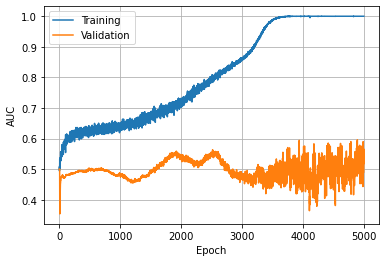

In [23]:
# Define callbacks

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('AUC') == 1.0):
            print("\nReached AUC of 1 so cancelling training!")
            self.model.stop_training = True

overfit_callback = myCallback()

checkpoints = tf.keras.callbacks.ModelCheckpoint('Models/P8_final_bestmodel_{}{}.h5'.format(domain, condition), 
                                                 monitor='val_AUC', 
                                                 save_best_only=True, 
                                                 mode = 'max') 

#callbacks_list = [overfit_callback, checkpoints] # Uncomment to use overfit_callback
callbacks_list = [checkpoints]

# Train Model
trainHistory = viz_model.fit(trainset, 
                             batch_size = batch_size, 
                             epochs = 5000,
                             validation_data = testset, 
                             callbacks = callbacks_list)
 
# Plot TrainHistory
plt.plot(trainHistory.history['AUC'])

plt.plot(trainHistory.history['val_AUC'])
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()
 

# Save Model

In [24]:

# Save Model
viz_model.save('Models/P8_final_{}{}'.format(domain, condition))

# Save TrainHistory
with open('Models/P8_trainHistory_{}{}.pkl'.format(domain, condition), 'wb') as f:
    pickle.dump(trainHistory, f)


INFO:tensorflow:Assets written to: Models/P8_final_5__P__closed/assets
INFO:tensorflow:Assets written to: ram://19a428b8-7784-4179-97bd-adf45640efe4/assets


## Save Predictions from best Model 

In [27]:
# Load best-trained model (from ModelCheckpoint callback)
viz_model = keras.models.load_model('Models/P8_final_bestmodel_{}{}.h5'.format(domain, condition))

# Predict with best-trained Model; List-comprehension for convenient format to read into R for ROC analysis
model_predictions = viz_model.predict(testset)
np.save("Predictions/P8_prediction_%s%s.npy"%(domain, condition),[pred[0] for pred in model_predictions])

# ROC-Curve and Confusion Matrix

In [32]:
# Load best Model from Training procedure
viz_model = keras.models.load_model('Models/P8_final_bestmodel_{}{}.h5'.format(domain, condition))

# Predict with best-trained Model
model_predictions = viz_model.predict(testset)

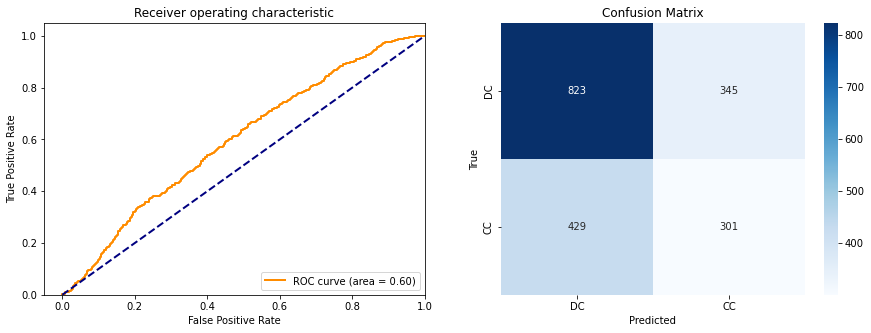

In [33]:
# Build arrays for GradCAM and predictions to inspect the network's decision making

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_targets = np.load("Data/target_test%s%s.npy"%(domain, condition))

pred = [i[0] for i in model_predictions] # Extract logits from model prediction (every logit is in a single array)
fpr, tpr, _ = roc_curve(test_targets, pred)# Compute False positive and true positive rate
roc_auc = auc(fpr, tpr) #Compute AUC

# Plot AUC and Confusion Matrix next to each other
fig, ax = plt.subplots(1,2,figsize = (15,5))

# Plot AUC
lw = 2 #linewidth
ax[0].plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)

ax[0].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
ax[0].set_xlim([-0.05, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("Receiver operating characteristic")
ax[0].legend(loc="lower right")

# Confusion Matrix
predictions = [round(i[0]) for i in model_predictions] #Round model predictions to 0 and 1
confmat = confusion_matrix(test_targets, predictions) # Build Confusion Matrix

#Plot Confusion Matrix
ax[1] = sns.heatmap(confmat, annot=True, fmt="d", cmap = "Blues", xticklabels = ["DC","CC"], yticklabels = ["DC","CC"])
ax[1].set_ylabel("True")
ax[1].set_xlabel("Predicted")
ax[1].set_title("Confusion Matrix")

plt.show()
   

# Evaluation: GradCAM

In this part, the classification of the best model (the model with the highest val AUC during training) is examined using GradCAM. GradCAM is used through the tf_explain package (https://github.com/sicara/tf-explain). Most of the code below is actually just making the graphs pretty, GradCAM itself is very easy to implement.

In [47]:
# Load best Model from Training procedure
viz_model = keras.models.load_model('Models/P8_final_bestmodel_{}{}.h5'.format(domain, condition))

# Get the name of the last convolutional layer
for layer in viz_model.layers[::-1]: # Iterate through reversed layers
    if 'conv' in layer.name: # The name of the first (i.e., last, due to layer reversal) layer to contain "conv" in name breaks the loop 
        last_conv_layer_name = layer.name
        break

Display an image of power / phase, the corresponding heatmap, as well as the Heatmap superimposed on top of the image

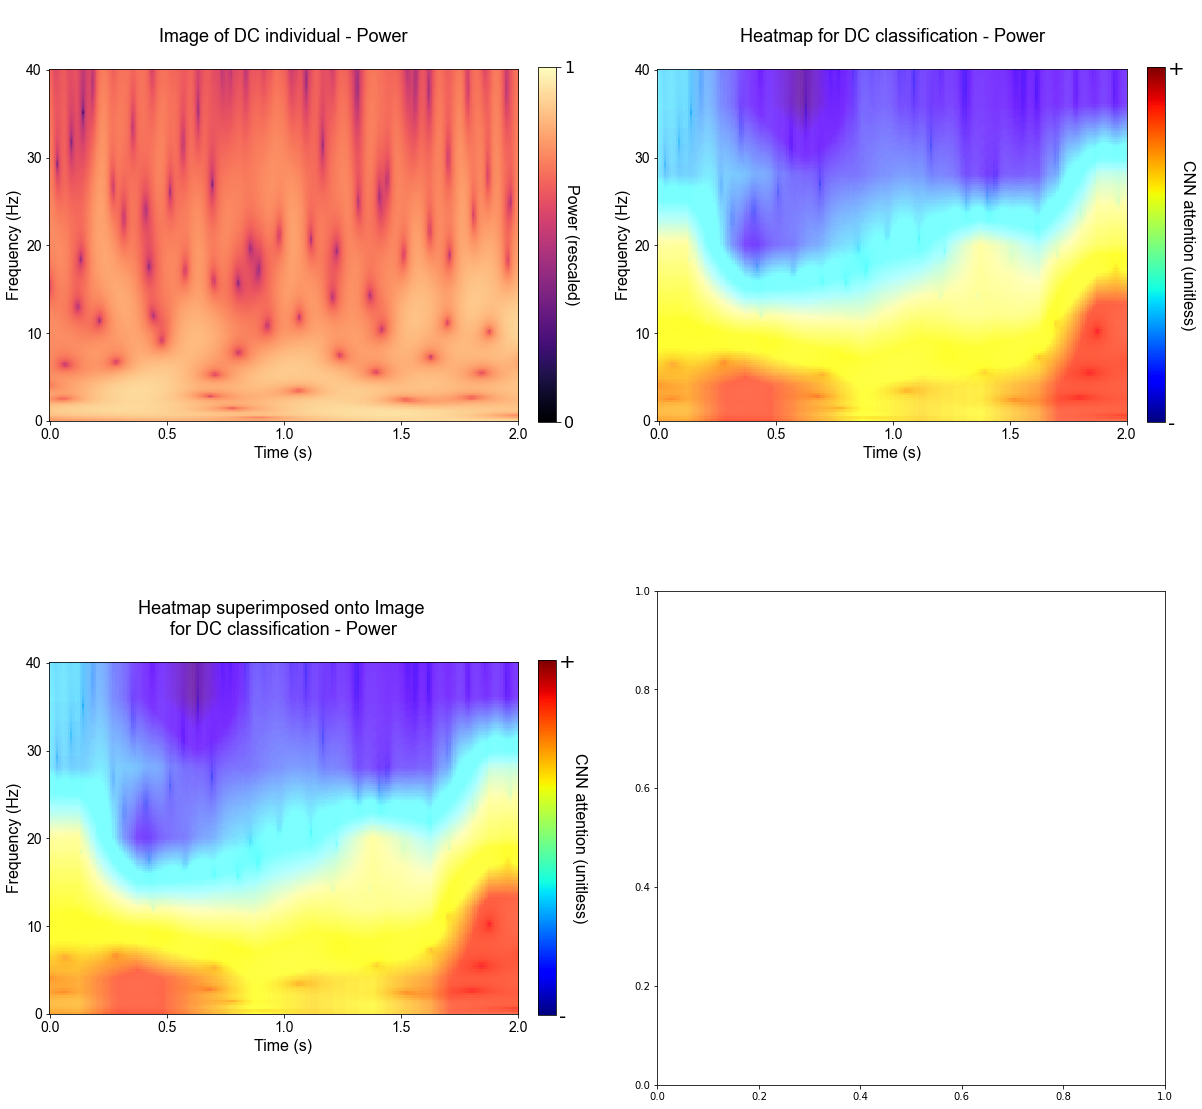

In [48]:
# Import relevant libraries
import matplotlib
import matplotlib.font_manager
import matplotlib.colors as colors
import cv2
from tf_explain.core.grad_cam import GradCAM

# Set font to Arial
hfont = {'fontname':'Arial'}

##################
#### Grad-CAM ####
##################

# Choose random picture to visualize
no = np.random.randint(len(p8_test_pics), size=1)[0]
data = (np.expand_dims(p8_test_pics[no],axis=0),test_targets[no])

# Instantiate GradCAM
explainer = GradCAM()

# Set the last layer to None to help visualization 
#(recommended here: https://github.com/sicara/tf-explain/issues/54)
model = tf.keras.models.clone_model(viz_model)
model.layers[-1].activation = None

# Use GradCAM at the last conv layer. 
# Image weight determines how much one sees the image, with 0 only showing the heatmap without the underlying image.
# Image weight is adapted depening on whether Phase or Power is plotted, as the magma colormap interferes more with the JET heatmap 
grid = explainer.explain(
    data, model, class_index = 0, layer_name=last_conv_layer_name, image_weight = 0.75 if angle else 0.5, use_guided_grads = True, colormap=cv2.COLORMAP_JET
)

grid_pure = explainer.explain(
    data, model, class_index = 0, layer_name=last_conv_layer_name, image_weight = 0 if angle else 0.5, use_guided_grads = True, colormap=cv2.COLORMAP_JET
)

#######################
#### Visualization ####
#######################

classlabel = "CC" if test_targets[no] == 1 else "DC"

# Display Image
fig, ax = plt.subplots(2, 2, figsize = (20,20))
image = ax[0,0].imshow(np.squeeze(data[0]), cmap = 'twilight' if angle == True else 'magma' ) # store this ax object to pass it to the colorbar later
ax[0,0].imshow(np.squeeze(data[0]))
ax[0,0].set_title("\nImage of %s individual - %s\n"%(classlabel, print_domain),**hfont, size = 18)
ax[0,0].set_yticks(np.linspace(0,149.5,5), rotation = 45) # Subtract 0.5 from linspace end such that axis don't get streched
ax[0,0].set_yticklabels([round(i) for i in np.linspace(40,0,5)],**hfont, size = 14)
ax[0,0].set_xticks(np.linspace(0,199.5,5), rotation = 45) # Subtract 0.5 from linspace end such that axis don't get streched
ax[0,0].set_xticklabels(np.linspace(0,2,5), **hfont, size = 14)
ax[0,0].tick_params(axis="x", bottom=True, top = False, labelbottom=True, labeltop=False)
ax[0,0].set_xlabel("Time (s)", **hfont, size = 16)
ax[0,0].set_ylabel("Frequency (Hz)", **hfont, size = 16)

#Customize Colorbar
cbar_0 = plt.colorbar(image, ax = ax[0,0],fraction=0.035, pad=0.04, ticks = [np.squeeze(data[0]).min(),np.squeeze(data[0]).max()])
cbar_0.ax.tick_params(size = 5, labelsize=16) 
# Adapt caption of colorbar depending on whether Phase or Power is plotted
if angle:
    cbar_0.ax.set_ylabel('Phase (in Degree)\n\n\n', fontsize = 16, rotation=270, **hfont)
    cbar_0.ax.set_yticklabels(['-π', 'π'])
else:
    cbar_0.ax.set_ylabel('Power (rescaled)\n\n\n', fontsize = 16, rotation=270, **hfont)
    cbar_0.ax.set_yticklabels(['0', '1'])
    

# Display Heatmap
mat = ax[0,1].matshow(grid_pure, cmap = 'jet') # store this ax object to pass it to the colorbar later
ax[0,1].matshow(grid_pure)
ax[0,1].set_title("Heatmap for %s classification - %s\n"%(classlabel, print_domain),**hfont, size = 18)
ax[0,1].set_yticks(np.linspace(0,149.5,5), rotation = 45) # Subtract 0.5 from linspace end such that axis don't get streched
ax[0,1].set_yticklabels([round(i) for i in np.linspace(40,0,5)],**hfont, size = 14)
ax[0,1].set_xticks(np.linspace(0,199.5,5), rotation = 45) # Subtract 0.5 from linspace end such that axis don't get streched
ax[0,1].set_xticklabels(np.linspace(0,2,5), **hfont, size = 14)
ax[0,1].tick_params(axis="x", bottom=True, top = False, labelbottom=True, labeltop=False)
ax[0,1].set_xlabel("Time (s)", **hfont, size = 16)
ax[0,1].set_ylabel("Frequency (Hz)", **hfont, size = 16)

# Customize Colorbar
cbar_1 = plt.colorbar(mat, ax = ax[0,1],fraction=0.035, pad=0.04, ticks = [grid.min(),grid.max()])
cbar_1.ax.tick_params(size = 0, labelsize=20) 
cbar_1.ax.set_ylabel('CNN attention (unitless)\n\n\n', fontsize = 16, rotation=270,**hfont)
cbar_1.ax.set_yticklabels(['- ', '+ '])

# Display Heatmap
mat = ax[1,0].matshow(grid, cmap = 'jet') # store this ax object to pass it to the colorbar later
ax[1,0].matshow(grid)
ax[1,0].set_title("Heatmap superimposed onto Image \nfor %s classification - %s\n"%(classlabel, print_domain),**hfont, size = 18)
ax[1,0].set_yticks(np.linspace(0,149.5,5), rotation = 45) # Subtract 0.5 from linspace end such that axis don't get streched
ax[1,0].set_yticklabels([round(i) for i in np.linspace(40,0,5)],**hfont, size = 14)
ax[1,0].set_xticks(np.linspace(0,199.5,5), rotation = 45) # Subtract 0.5 from linspace end such that axis don't get streched
ax[1,0].set_xticklabels(np.linspace(0,2,5), **hfont, size = 14)
ax[1,0].tick_params(axis="x", bottom=True, top = False, labelbottom=True, labeltop=False)
ax[1,0].set_xlabel("Time (s)", **hfont, size = 16)
ax[1,0].set_ylabel("Frequency (Hz)", **hfont, size = 16)

# Customize Colorbar
cbar_2 = plt.colorbar(mat, ax = ax[1,0],fraction=0.035, pad=0.04, ticks = [grid.min(),grid.max()])
cbar_2.ax.tick_params(size = 0, labelsize=20) 
cbar_2.ax.set_ylabel('CNN attention (unitless)\n\n\n', fontsize = 16, rotation=270,**hfont)
cbar_2.ax.set_yticklabels(['- ', '+ '])

#plt.tight_layout()
plt.show()

# Class-wise mean Heatmap

As the pictures widely vary, the idea was to obtain a mean Heatmap for each of the two classes. Doing so, I hoped to find some patterns that might hint on differences in specific frequencies for example. 

In [49]:
#####################################
#### Compute class-wise heatmaps ####
#####################################

# Define function to retrieve the GradCAM heatmaps for all members of one class
def heatmaps_per_class(viz_model, test_images, test_target, target):
    
    # List comprehension: select those images where test_targets == target
    subset = [test_images[i] for i in np.where(test_targets == target)[0]]

    # Instantiate an empty array to store heatmaps in, with length of the respective subset as first dimension, and shape of the heatmap as the other dimensions.
    heatmap_array = np.empty(shape = (len(subset),150, 200, 3), dtype = "uint8")

    for i in range(len(subset)):
        data = (np.expand_dims(subset[i],axis=0),target) #Format data to GradCAM-readable format

        # Instantiate GradCAM
        explainer = GradCAM()

        # Set the last layer to None to help visualization 
        #(recommended here: https://github.com/sicara/tf-explain/issues/54)
        model = tf.keras.models.clone_model(viz_model)
        model.layers[-1].activation = None

        # Use GradCAM at the last conv layer. Image weight determines how much one sees the image, with 0 only showing hte heatmap without the underlying image. 
        heatmap = explainer.explain(
            data, model, class_index = 0, layer_name=last_conv_layer_name, image_weight = 0, use_guided_grads = True, colormap=cv2.COLORMAP_JET
        )

        heatmap_array[i,:,:] = heatmap
    
    return(heatmap_array)

# Call functions
heatmaps_cc = heatmaps_per_class(viz_model, p8_test_pics, test_targets, target = 1) #Target = 1 for CC
heatmaps_dc = heatmaps_per_class(viz_model, p8_test_pics, test_targets, target = 0) # Target = 0 for DC

# Save mean heatmaps
with open("Predictions/mean_heatmaps_cc_5%s%s.pkl"%(domain, condition),"wb") as f:
    pickle.dump(heatmaps_cc, f)

with open("Predictions/mean_heatmaps_dc_5%s%s.pkl"%(domain, condition),"wb") as f:
    pickle.dump(heatmaps_dc, f)
    

### Plot mean Heatmaps

Running the visualization cell requires to run the Grad-CAM cell above first

In [22]:
# Load previously saved heatmaps

with open("Predictions/mean_heatmaps_cc_5%s%s.pkl"%(domain, condition),"rb") as f:
    heatmaps_cc = pickle.load(f)

with open("Predictions/mean_heatmaps_dc_5%s%s.pkl"%(domain, condition),"rb") as f:
    heatmaps_dc = pickle.load(f)
    

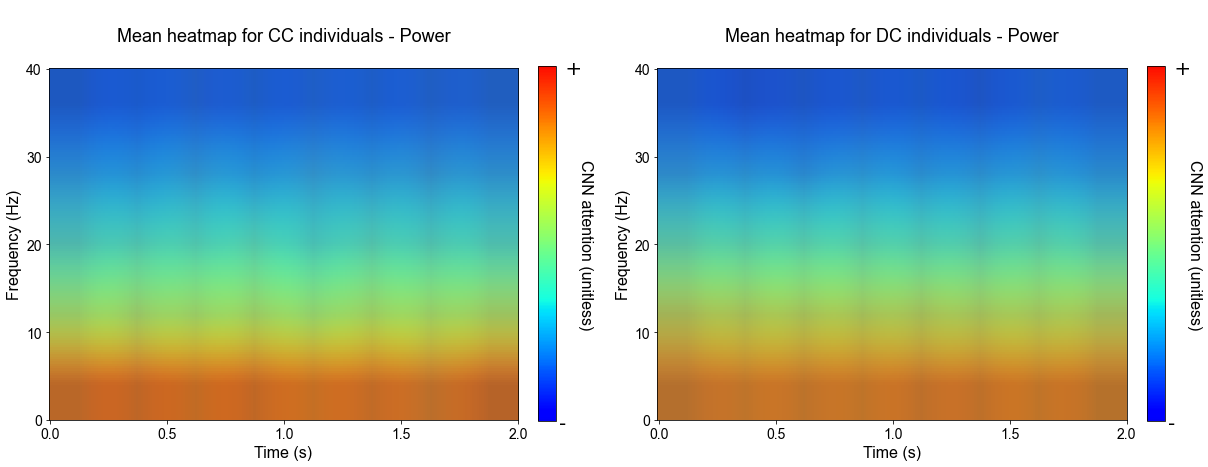

In [50]:
#######################
#### Visualization ####
#######################

# Manually truncate colormap to fit the colorscale in the mean heatmaps
# Function adapted from Stack Overflow: https://stackoverflow.com/questions/18926031
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


# Plot mean heatmaps
mean_cc = np.mean(heatmaps_cc, axis = 0).astype(int) # Average over first dimension, i.e., over all heatmaps
mean_dc = np.mean(heatmaps_dc, axis = 0).astype(int)

new_cmap = truncate_colormap(plt.get_cmap('jet'), mean_cc.min() / 255, mean_cc.max() / 255)

fig, ax = plt.subplots(1,2, figsize = (20,10))
mat_0 = ax[0].matshow(mean_cc,cmap = new_cmap) # store this ax object to pass it to the colorbar later
ax[0].matshow(mean_cc) 
ax[0].set_title("\nMean heatmap for CC individuals - %s\n"%print_domain, **hfont, size = 18)
ax[0].set_yticks(np.linspace(0,149.5,5), rotation = 45) # Subtract 0.5 from linspace end such that axis don't get streched
ax[0].set_yticklabels([round(i) for i in np.linspace(40,0,5)],**hfont, size = 14)
ax[0].set_xticks(np.linspace(0,199.5,5), rotation = 45) # Subtract 0.5 from linspace end such that axis don't get streched
ax[0].set_xticklabels(np.linspace(0,2,5), **hfont, size = 14)
ax[0].tick_params(axis="x", bottom=True, top = False, labelbottom=True, labeltop=False)
ax[0].set_xlabel("Time (s)", **hfont, size = 16)
ax[0].set_ylabel("Frequency (Hz)", **hfont, size = 16)

mat_1 = ax[1].matshow(mean_dc,cmap = new_cmap) # store this ax object to pass it to the colorbar later
ax[1].matshow(mean_dc) 
ax[1].set_title("\nMean heatmap for DC individuals - %s\n"%print_domain,**hfont, size = 18)
ax[1].set_yticks(np.linspace(0,149.5,5), rotation = 45) # Subtract 0.5 from linspace end such that axis don't get streched
ax[1].set_yticklabels([round(i) for i in np.linspace(40,0,5)],**hfont, size = 14)
ax[1].set_xticks(np.linspace(0,199.5,5), rotation = 45) # Subtract 0.5 from linspace end such that axis don't get streched
ax[1].set_xticklabels(np.linspace(0,2,5), **hfont, size = 14)
ax[1].tick_params(axis="x", bottom=True, top = False, labelbottom=True, labeltop=False)
ax[1].set_xlabel("Time (s)", **hfont, size = 16)
ax[1].set_ylabel("Frequency (Hz)", **hfont, size = 16)


# Add colorbars
cbar_0 = plt.colorbar(mat_0, ax = ax[0],fraction=0.035, pad=0.04, ticks = [mean_cc.min(),mean_cc.max()])
cbar_0.ax.tick_params(size = 0, labelsize=20) 
cbar_0.ax.set_ylabel('CNN attention (unitless)', fontsize = 16, rotation=270,**hfont)
cbar_0.ax.set_yticklabels(['- ', ' + '])

cbar_1 = plt.colorbar(mat_1, ax = ax[1],fraction=0.035, pad=0.04, ticks = [mean_dc.min(),mean_dc.max()])
cbar_1.ax.tick_params(size = 0, labelsize=20) 
cbar_1.ax.set_ylabel('CNN attention (unitless)', fontsize = 16, rotation=270,**hfont)
cbar_1.ax.set_yticklabels(['- ', ' + '])

plt.show()

# Plot all TrainHistories for Appendix

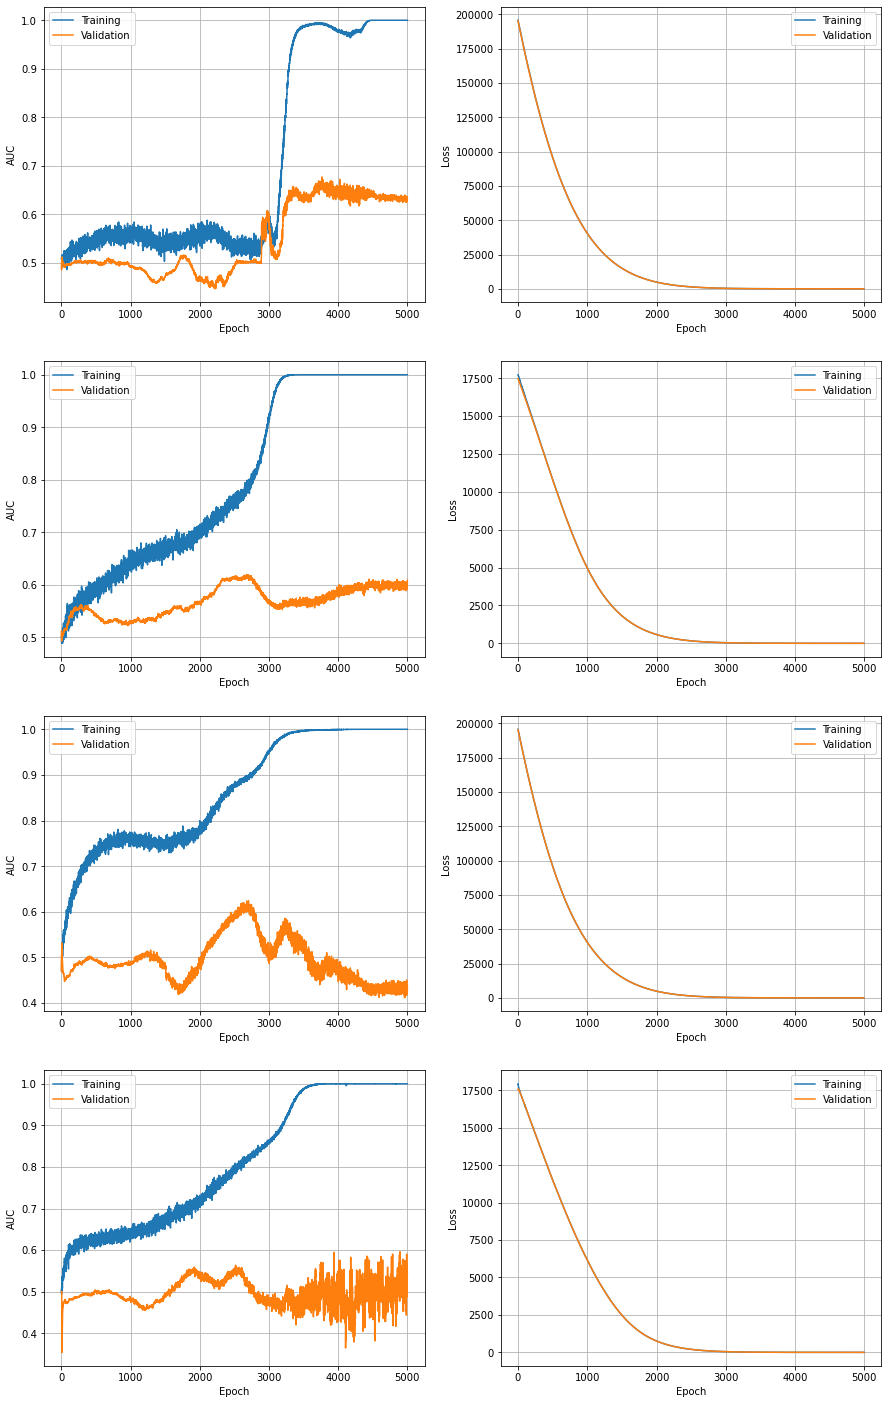

In [28]:
import os 
import pickle

os.chdir('/home/bpn/Documents/Max')
    
fig, ax = plt.subplots(4,2,figsize = (15,25))

for i,d,c in zip(range(4), ["_A_","_A_","_P_","_P_"], ["32","P8","32","P8"]):
    
    if c == "32":
        path = "32_channels/Models/32_trainHistory_final_%s_closed.pkl"%d
    else:
        path = "P8_final/Models/P8_trainHistory_%s_closed.pkl"%d
    
    with open(path, 'rb') as f:
        trainHistory = pickle.load(f)
        
    ax[i,0].plot(trainHistory.history['AUC'])
    ax[i,0].plot(trainHistory.history['val_AUC'])
    ax[i,0].set_ylabel('AUC')
    ax[i,0].set_xlabel('Epoch')
    ax[i,0].legend(['Training', 'Validation'])
    ax[i,0].grid()
    ax[i,1].plot(trainHistory.history['loss'][5:])
    ax[i,1].plot(trainHistory.history['val_loss'][5:])
    ax[i,1].set_ylabel('Loss')
    ax[i,1].set_xlabel('Epoch')
    ax[i,1].legend(['Training', 'Validation'])
    ax[i,1].grid()

plt.show()


Have a lot of fun continuing this project! I wish I had more time to squeeze everthing out of this data, as I'm sure there is something waiting to be found! <br> Best, Max